# **Ανάλυση Ιατρικών Εικόνων MedMNIST με CNN, Transfer Learning & Vision Transformers (PyTorch)**

Σκλαβενίτης Γεώργιος 10708 gsklaven@ece.auth.gr

# 0. Περιγραφή του Dataset

In [ ]:
# Install the MedMNIST library
!pip install medmnist

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 10.6 MB/s eta 0:00:00


In [ ]:
# All imports needed
import numpy as np
import torch
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torchvision.models as models
from collections import Counter
from torch import nn as nn
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Import dataset
from medmnist import BloodMNIST

# Create dataset splits (train, validation, test)
# 'download=True' downloads the dataset if it doesn't exist
# 'size=28' specifies the image resolution (28x28) as given in medmnist.com
train_dataset = BloodMNIST(split='train', download=True, size=28)
val_dataset = BloodMNIST(split='val', download=True, size=28)
test_dataset = BloodMNIST(split='test', download=True, size=28)

100%|██████████| 35.5M/35.5M [00:20<00:00, 1.74MB/s]


In [ ]:
# Check for other image dimensions (e.g., 32x32)
try:
    dataset_32 = BloodMNIST(split="train", download=True, size=32)
    img, _ = dataset_32[0]
    print(f"Test 32x32: Success. The images have size: {img.size}")
except Exception as e:
    print("The 32x32 version is not available for this dataset.")

The 32x32 version is not available for this dataset.


In [ ]:
# Display basic image information
first_image, first_label = train_dataset[0]
image_array = np.array(first_image)

print(f"Image Information")
print(f"Resolution: {image_array.shape}")

# Check if the image is RGB or Grayscale
if len(image_array.shape) == 3 and image_array.shape[2] == 3:
    print("Type: RGB")
else:
    print("Type: Grayscale")

Image Information
Resolution: (28, 28, 3)
Type: RGB


In [ ]:
# Display dataset and class information
info = train_dataset.info

description = info['description']
print(f"Description: {description}")

labels_map = info['label']

print(f"\nClasses: {len(labels_map)}")
for key, value in labels_map.items():
    print(f"Label {key}: {value}")

Description: The BloodMNIST is based on a dataset of individual normal cells, captured from individuals without infection, hematologic or oncologic disease and free of any pharmacologic treatment at the moment of blood collection. It contains a total of 17,092 images and is organized into 8 classes. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images with resolution 3×360×363 pixels are center-cropped into 3×200×200, and then resized into 3×28×28.

Classes: 8
Label 0: basophil
Label 1: eosinophil
Label 2: erythroblast
Label 3: immature granulocytes(myelocytes, metamyelocytes and promyelocytes)
Label 4: lymphocyte
Label 5: monocyte
Label 6: neutrophil
Label 7: platelet


In [ ]:
print(f"Size of Splits")
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Size of Splits
Training set: 11959 images
Validation set: 1712 images
Test set: 3421 images


In [ ]:
# Extract all labels from the training set to check distribution
train_labels = [y[0] for _, y in train_dataset]
counts = Counter(train_labels)

print(f"--- Class Distribution (Imbalance Check) ---")
print("Number of images per class in Training Set:")
for label_id, count in sorted(counts.items()):
    class_name = labels_map[str(label_id)]
    print(f" - {class_name}: {count}")

--- Class Distribution (Imbalance Check) ---
Number of images per class in Training Set:
 - basophil: 852
 - eosinophil: 2181
 - erythroblast: 1085
 - immature granulocytes(myelocytes, metamyelocytes and promyelocytes): 2026
 - lymphocyte: 849
 - monocyte: 993
 - neutrophil: 2330
 - platelet: 1643


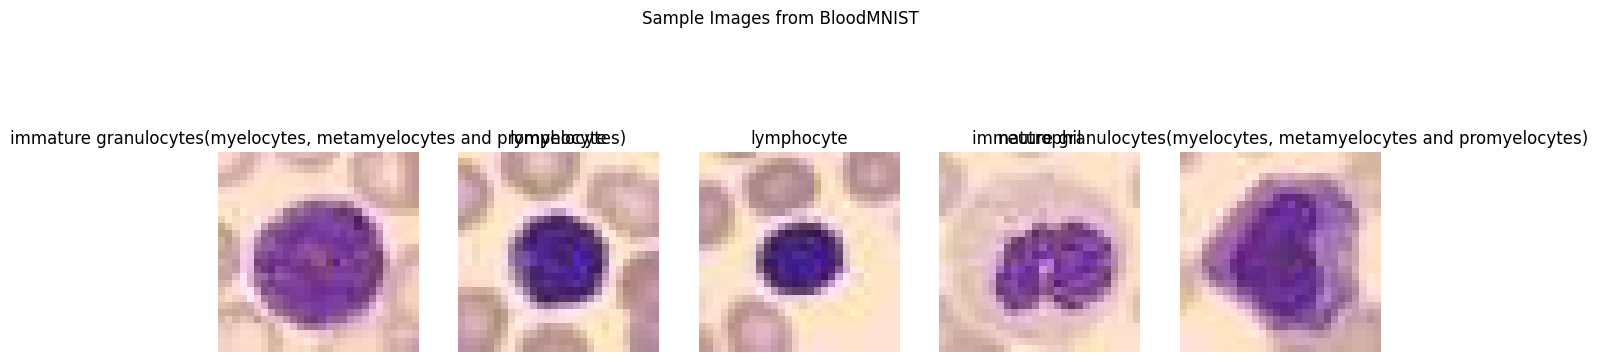

In [ ]:
# Visualize 5 random samples
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
indices = np.random.choice(len(train_dataset), 5, replace=False)

for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    class_name = labels_map[str(label[0])]

    axes[i].imshow(img) # Display image
    axes[i].set_title(class_name) # Set title
    axes[i].axis('off') # Hide axes

plt.suptitle("Sample Images from BloodMNIST") # Central title
plt.show()

# Global Functions

In [ ]:
def train_loop(model, dataloader, optimizer, criterion, device):
    """
    Executes one training cycle (epoch) for a model.

    Args:
        model (torch.nn.Module): The model to be trained.
        dataloader (torch.utils.data.DataLoader): The DataLoader for the training set.
        optimizer (torch.optim.Optimizer): The optimizer.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device (CPU or GPU) on which training will be executed.

    Returns:
        tuple: A tuple containing the average loss and accuracy.
    """

    # Set the model to training mode
    model.train()

    total_loss = 0
    correct = 0
    total = 0

    # Iterate over training data
    for batch, (images, labels) in enumerate(dataloader):

        # Transfer images and labels to the specified device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.squeeze(1) # Convert labels to 1D (if necessary)

        output = model(images) # Forward pass (input -> model -> prediction)
        loss = criterion(output, labels) # Calculate the loss function
        total_loss += loss.item()

        optimizer.zero_grad() # Zero out previous gradients
        loss.backward() # Backpropagation (gradient calculation)
        optimizer.step() # Update parameters

        preds = output.argmax(dim=1) # Get the class with the highest probability
        correct += (preds == labels).sum().item() # Count correct predictions
        total += labels.size(0) # Count total samples

        if batch % 100 == 0:
          current = batch * dataloader.batch_size + len(images)
          print(f"loss: {loss.item():>7f}  [{current:>5d}/{len(dataloader.dataset):>5d}]")

    return total_loss / len(dataloader), correct / total # Return average loss and accuracy

In [ ]:
def test_loop(model, dataloader, criterion, device):
    """
    Evaluates the performance of a model on a dataset.

    Args:
        model (torch.nn.Module): The model to be evaluated.
        dataloader (torch.utils.data.DataLoader): The DataLoader for the validation/test set.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device (CPU or GPU) on which the evaluation will be executed.

    Returns:
        tuple: A tuple containing the average loss, accuracy, all predictions
               and all true labels.
    """

    # Set the model to evaluation mode (disables dropout/batchnorm updates)
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    all_preds = [] # List to store all predictions
    all_labels = [] # List to store all true labels

    # Disable gradient calculation to save memory and speed
    with torch.no_grad():
        for images, labels in dataloader:

            # Transfer images and labels to the specified device
            images = images.to(device)
            labels = labels.to(device)
            labels = labels.squeeze(1) # Convert labels to 1D (if necessary)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.detach().cpu().numpy()) # Store predictions on CPU
            all_labels.extend(labels.detach().cpu().numpy()) # Store labels on CPU

    return total_loss / len(dataloader), correct / total, np.array(all_preds), np.array(all_labels)

In [ ]:
def run_training(model, train_loader, val_loader, optimizer, criterion, device, epochs):
    """
    Executes the training and evaluation process of a model for a specified number of epochs.

    Args:
        model (torch.nn.Module): The model to be trained.
        train_loader (torch.utils.data.DataLoader): DataLoader for the training set.
        val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.
        optimizer (torch.optim.Optimizer): The optimizer.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device (CPU or GPU).
        epochs (int): The number of epochs.

    Returns:
        dict: A dictionary with the history of losses and accuracies for training and validation.
    """
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    print(f"Starting training on {device} for {epochs} epochs...")

    for epoch in range(epochs):
        # Training
        t_loss, t_acc = train_loop(model, train_loader, optimizer, criterion, device)

        # Evaluation on the Validation set
        v_loss, v_acc, _, _ = test_loop(model, val_loader, criterion, device)

        # Store history
        history['train_loss'].append(t_loss)
        history['train_acc'].append(t_acc)
        history['val_loss'].append(v_loss)
        history['val_acc'].append(v_acc)

        # Print progress per epoch
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f} | Val Acc: {v_acc:.4f}")

    return history

In [ ]:
def evaluate_and_visualize(model, test_loader, criterion, device, history, class_names):
    """
    Visualizes training curves, evaluates the model on the test set
    and displays the confusion matrix and classification report.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test set.
        criterion (torch.nn.Module): The loss function.
        device (torch.device): The device (CPU or GPU).
        history (dict): The training history (losses, accuracies).
        class_names (list): List of class names.
    """

    # Visualize loss and accuracy curves
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss curve
    plt.subplot(1, 2, 1) # Create a 1x2 subplot, in the 1st position
    plt.plot(epochs_range, history['train_loss'], label='Training Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy curve
    plt.subplot(1, 2, 2) # Create a 1x2 subplot, in the 2nd position
    plt.plot(epochs_range, history['val_acc'], label='Validation Accuracy', color='green')
    plt.plot(epochs_range, history['train_acc'], label='Training Accuracy', color='blue')
    plt.title('Training & Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    # Evaluate on Test Set
    print("\nEvaluating on Test Set...")
    test_loss, test_acc, preds, labels = test_loop(model, test_loader, criterion, device)
    print(f"Final Test Loss: {test_loss:.4f}")
    print(f"Final Test Accuracy: {test_acc*100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(labels, preds)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(labels, preds, target_names=class_names))

# 1. CNN από την αρχή

MODELS

In [ ]:
# Training Transformation
# Introduce 'randomness' here to make the dataset more challenging and robust
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # 50% probability for horizontal flip
    transforms.RandomRotation(degrees=10),   # Random rotation +/- 10 degrees
    transforms.ToTensor()                    # Convert to Tensor (necessary for PyTorch)
])

# Validation & Test Transformation (WITHOUT Augmentation)
# Keep the images 'clean' for accurate evaluation
eval_transform = transforms.Compose([
    transforms.ToTensor()
])

# Define Datasets with appropriate transformations
train_dataset = BloodMNIST(
    split='train',
    download=True,
    size=28,
    transform=train_transform # Apply training transformations
)

val_dataset = BloodMNIST(
    split='val',
    download=True,
    size=28,
    transform=eval_transform # Apply evaluation transformations
)

test_dataset = BloodMNIST(
    split='test',
    download=True,
    size=28,
    transform=eval_transform # Apply evaluation transformations
)

In [ ]:
BATCH_SIZE = 64

# Create DataLoaders for each split
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True) # shuffle=True for random order in training data
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False) # shuffle=False for consistent evaluation
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders are ready!")

DataLoaders are ready!


SIMPLE

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=8):
        super(SimpleCNN, self).__init__()

        # --- BLOCK 1 ---
        # Input image: [Batch, 3, 28, 28] (RGB)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1) # 3 input channels (RGB)

        # Output size calculation Conv1:
        # Formula: ((input_size - kernel_size + 2 * padding) / stride) + 1
        # (28 - 3 + 2 * 1) / 1 + 1 = 28
        # Output shape after Conv1: [Batch, 32, 28, 28]

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Output size calculation Pool1:
        # 28 / 2 = 14
        # Output shape after Pool1: [Batch, 32, 14, 14]


        # --- BLOCK 2 ---
        # Input to Conv2 is the output of Pool1: 14x14 with 32 channels
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 32 input channels, 64 output channels

        # Output size calculation Conv2:
        # (14 - 3 + 2 * 1) / 1 + 1 = 14
        # Output shape after Conv2: [Batch, 64, 14, 14]

        # Output size calculation Pool2:
        # 14 / 2 = 7
        # Output shape after Pool2: [Batch, 64, 7, 7]


        # --- BLOCK 3 ---
        # Input to Conv3 is the output of Pool2: 7x7 with 64 channels
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Output size calculation Conv3:
        # (7 - 3 + 2 * 1) / 1 + 1 = 7
        # Output shape after Conv3: [Batch, 128, 7, 7]

        # Output size calculation Pool3:
        # 7 / 2 = 3.5 -> PyTorch rounds down (floor) to an integer
        # Result = 3
        # Output shape after Pool3: [Batch, 128, 3, 3]


        # Flatten and Fully Connected
        # Final Tensor shape: [Batch, 128, 3, 3]
        # Flattening: Channels * Height * Width
        self.flatten_dim = 128 * 3 * 3  # = 1152
        self.fc = nn.Linear(self.flatten_dim, num_classes) # Fully Connected layer with 8 output classes

    def forward(self, x):
        # Apply Block 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Apply Block 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Apply Block 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten parameters for the Linear layer
        x = x.flatten(1)

        # Classification
        x = self.fc(x)
        return x

# Transfer the model to GPU if available, otherwise to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=8).to(device)
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=1152, out_features=8, bias=True)
)


Starting training on cuda for 50 epochs...
loss: 2.086472  [   64/11959]
loss: 1.025056  [ 6464/11959]
Epoch 1/50 | Train Loss: 1.2205 | Val Loss: 0.7407 | Val Acc: 0.7395
loss: 0.706741  [   64/11959]
loss: 0.615501  [ 6464/11959]
Epoch 2/50 | Train Loss: 0.7113 | Val Loss: 0.6566 | Val Acc: 0.7640
loss: 0.558502  [   64/11959]
loss: 0.628432  [ 6464/11959]
Epoch 3/50 | Train Loss: 0.5813 | Val Loss: 0.5372 | Val Acc: 0.7991
loss: 0.406188  [   64/11959]
loss: 0.386301  [ 6464/11959]
Epoch 4/50 | Train Loss: 0.5088 | Val Loss: 0.4369 | Val Acc: 0.8464
loss: 0.428783  [   64/11959]
loss: 0.640939  [ 6464/11959]
Epoch 5/50 | Train Loss: 0.4499 | Val Loss: 0.4042 | Val Acc: 0.8581
loss: 0.327579  [   64/11959]
loss: 0.303149  [ 6464/11959]
Epoch 6/50 | Train Loss: 0.4029 | Val Loss: 0.3665 | Val Acc: 0.8750
loss: 0.371174  [   64/11959]
loss: 0.327082  [ 6464/11959]
Epoch 7/50 | Train Loss: 0.3621 | Val Loss: 0.3165 | Val Acc: 0.8820
loss: 0.294372  [   64/11959]
loss: 0.361803  [ 6464/1

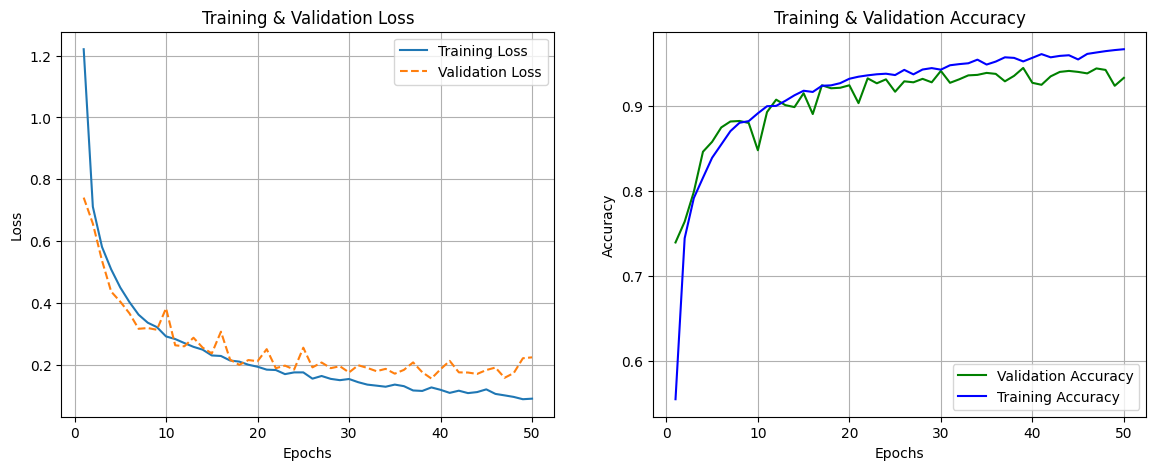


Evaluating on Test Set...
Final Test Loss: 0.2286
Final Test Accuracy: 93.13%


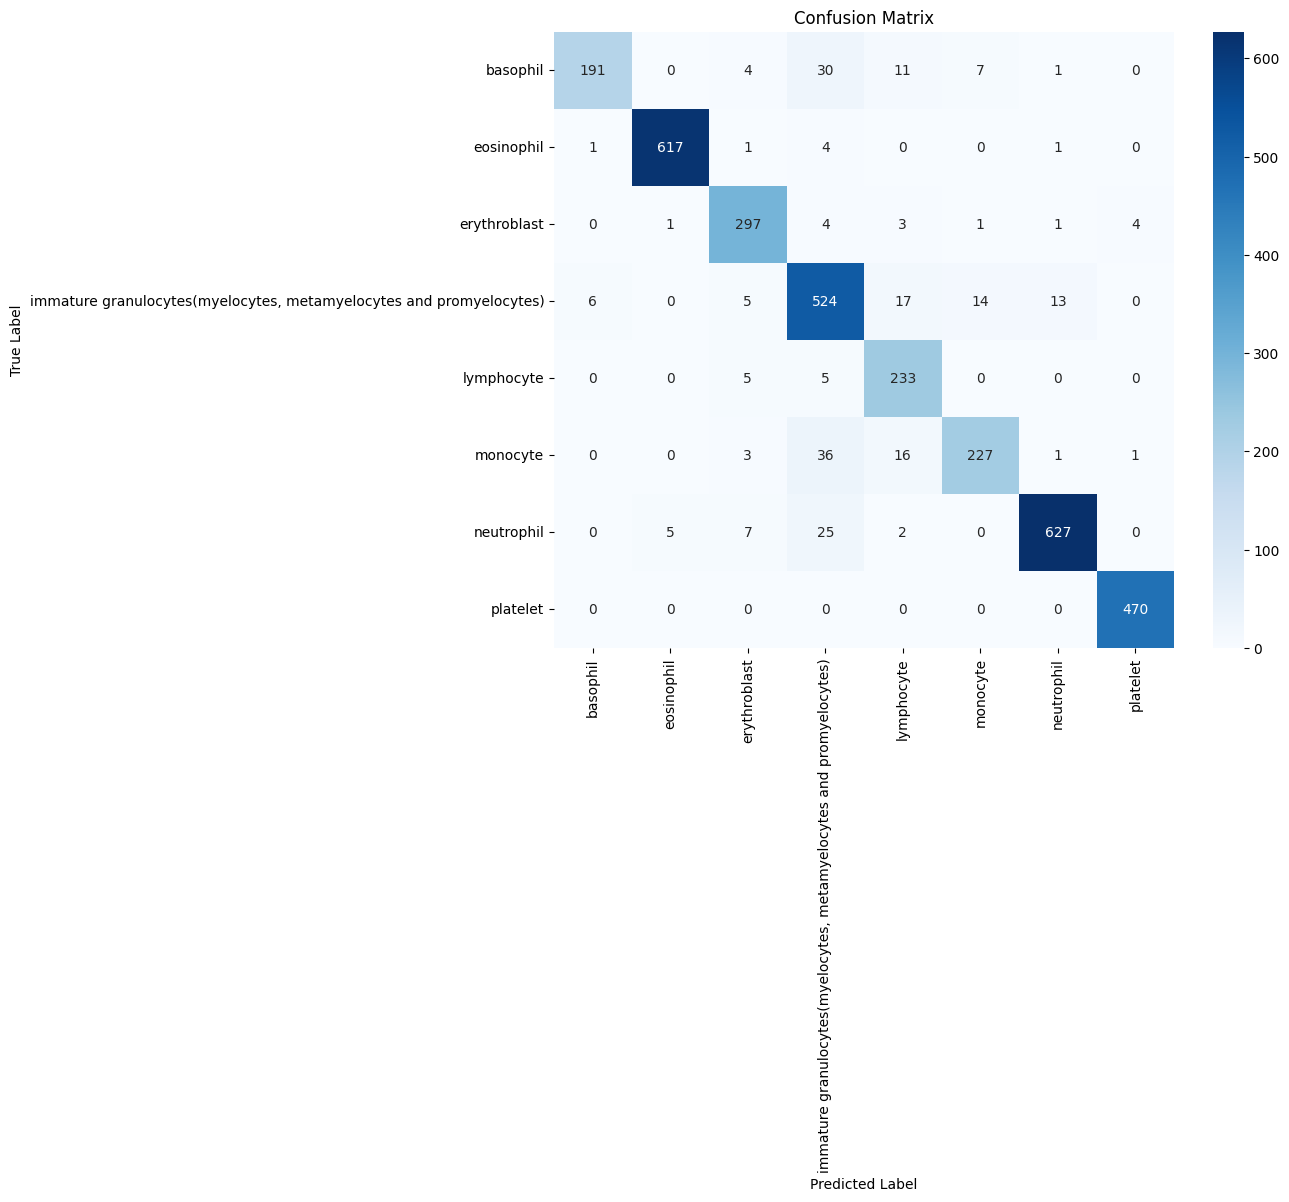


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.96      0.78      0.86       244
                                                         eosinophil       0.99      0.99      0.99       624
                                                       erythroblast       0.92      0.95      0.94       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.83      0.91      0.87       579
                                                         lymphocyte       0.83      0.96      0.89       243
                                                           monocyte       0.91      0.80      0.85       284
                                                         neutrophil       0.97      0.94      0.96       666
                                                           platelet       0.99      1.00      0.99     

In [ ]:
# Hyperparameters

# Seed for reproducibility of results
torch.manual_seed(42)
# Define epochs
EPOCHS = 50
# Define learning rate
learning_rate = 1e-3

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Run training
history = run_training(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=EPOCHS)

# Retrieve class names for visualization
class_names = [labels_map[str(i)] for i in range(8)]

# Evaluate and visualize results
evaluate_and_visualize(model, test_dataloader, criterion, device, history, class_names)

BATCH NORMALIZATION

In [ ]:
class CNNWithBatch(nn.Module):
    def __init__(self, num_classes=8):
        super(CNNWithBatch, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32) # Batch Normalization after conv1
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64) # Batch Normalization after conv2

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128) # Batch Normalization after conv3

        self.flatten_dim = 128 * 3 * 3  # = 1152
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        # Apply Block 1
        x = self.conv1(x)
        x = self.bn1(x) # Apply Batch Normalization
        x = F.relu(x)
        x = self.pool(x)

        # Apply Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Apply Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten parameters for the Linear layer
        x = x.flatten(1)

        # Classification
        x = self.fc(x)
        return x

# Transfer the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_with_batch = CNNWithBatch(num_classes=8).to(device)
print(model_with_batch)

CNNWithBatch(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=1152, out_features=8, bias=True)
)


Starting training on cuda for 45 epochs...
loss: 2.313216  [   64/11959]
loss: 0.552203  [ 6464/11959]
Epoch 1/45 | Train Loss: 0.6016 | Val Loss: 0.3634 | Val Acc: 0.8779
loss: 0.319494  [   64/11959]
loss: 0.237528  [ 6464/11959]
Epoch 2/45 | Train Loss: 0.3410 | Val Loss: 0.3079 | Val Acc: 0.8867
loss: 0.297615  [   64/11959]
loss: 0.238851  [ 6464/11959]
Epoch 3/45 | Train Loss: 0.2739 | Val Loss: 0.2370 | Val Acc: 0.9264
loss: 0.225142  [   64/11959]
loss: 0.196438  [ 6464/11959]
Epoch 4/45 | Train Loss: 0.2433 | Val Loss: 0.2206 | Val Acc: 0.9188
loss: 0.204617  [   64/11959]
loss: 0.343853  [ 6464/11959]
Epoch 5/45 | Train Loss: 0.2111 | Val Loss: 0.2494 | Val Acc: 0.9118
loss: 0.112936  [   64/11959]
loss: 0.149269  [ 6464/11959]
Epoch 6/45 | Train Loss: 0.1951 | Val Loss: 0.2485 | Val Acc: 0.9136
loss: 0.214698  [   64/11959]
loss: 0.218436  [ 6464/11959]
Epoch 7/45 | Train Loss: 0.1812 | Val Loss: 0.2152 | Val Acc: 0.9211
loss: 0.104748  [   64/11959]
loss: 0.119342  [ 6464/1

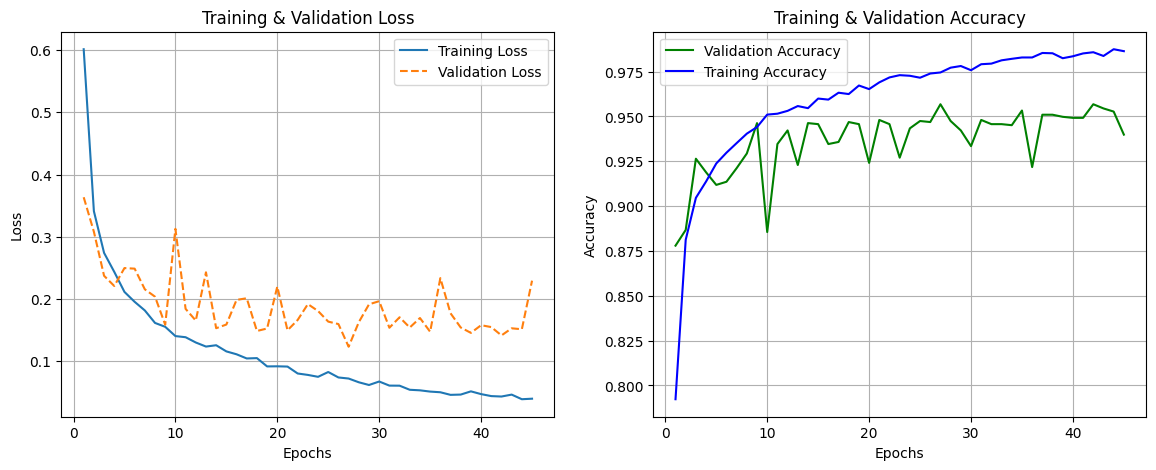


Evaluating on Test Set...
Final Test Loss: 0.2658
Final Test Accuracy: 93.13%


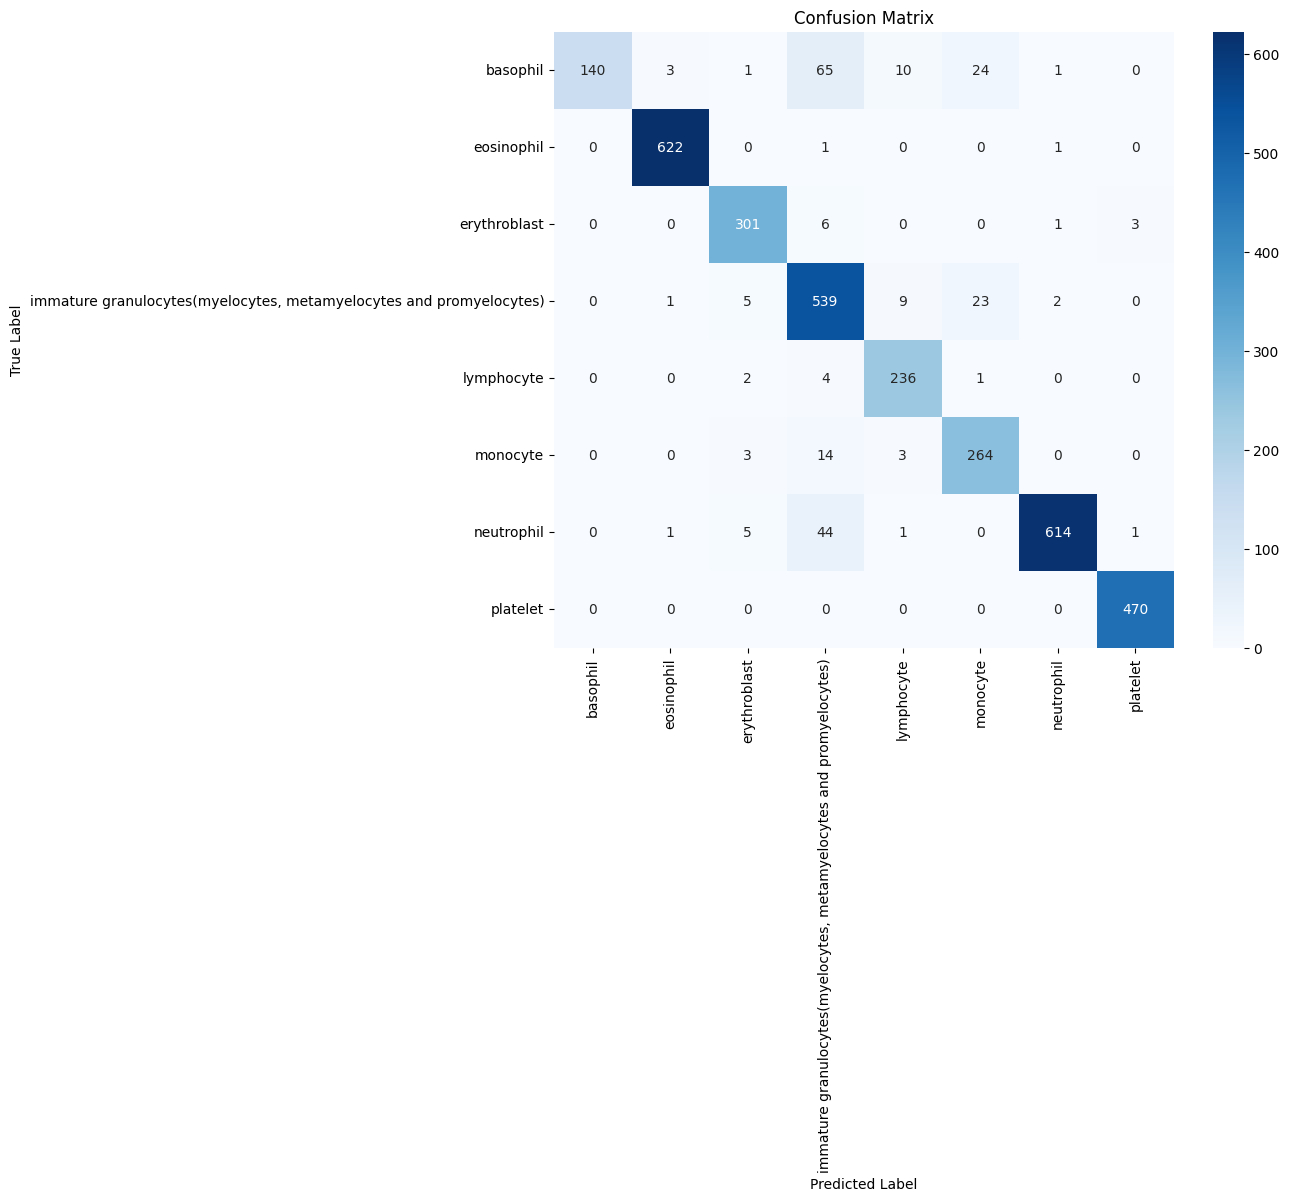


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       1.00      0.57      0.73       244
                                                         eosinophil       0.99      1.00      0.99       624
                                                       erythroblast       0.95      0.97      0.96       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.80      0.93      0.86       579
                                                         lymphocyte       0.91      0.97      0.94       243
                                                           monocyte       0.85      0.93      0.89       284
                                                         neutrophil       0.99      0.92      0.96       666
                                                           platelet       0.99      1.00      1.00     

In [ ]:
# Hyperparameters

# Seed for reproducibility
torch.manual_seed(42)
# Define epochs
EPOCHS = 45
# Define learning rate
learning_rate = 5e-4

# Initialize optimizer
optimizer = torch.optim.Adam(model_with_batch.parameters(), lr=learning_rate)
# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Run training
history = run_training(model_with_batch, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=EPOCHS)
# Retrieve class names for visualization
class_names = [labels_map[str(i)] for i in range(8)]
# Evaluate and visualize results
evaluate_and_visualize(model_with_batch, test_dataloader, criterion, device, history, class_names)

LAYER NORMALIZATION

In [ ]:
class CNNWithLayerNorm(nn.Module):
    def __init__(self, num_classes=8):
        super(CNNWithLayerNorm, self).__init__()

        # --- BLOCK 1 ---
        # Input: [Batch, 3, 28, 28]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # After conv1 + pool, spatial dimensions are 14x14 with 32 channels.
        # LayerNorm requires the exact shape of the feature map (C, H, W).
        self.ln1 = nn.LayerNorm([32, 14, 14])

        # --- BLOCK 2 ---
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # After conv2 + pool, spatial dimensions are 7x7 with 64 channels.
        self.ln2 = nn.LayerNorm([64, 7, 7])

        # --- BLOCK 3 ---
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # After conv3 + pool, spatial dimensions are 3x3 with 128 channels.
        self.ln3 = nn.LayerNorm([128, 3, 3])

        # --- FLATTEN & FULLY CONNECTED ---
        self.flatten_dim = 128 * 3 * 3
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.ln1(x)  # Apply Layer Norm at the end of the block

        # Block 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.ln2(x)

        # Block 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.ln3(x)

        # Flatten and classify
        x = x.flatten(1)
        x = self.fc(x)
        return x

# Transfer the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize model
model_ln = CNNWithLayerNorm(num_classes=8).to(device)

Starting training on cuda for 45 epochs...
loss: 2.246878  [   64/11959]
loss: 0.660847  [ 6464/11959]
Epoch 1/45 | Train Loss: 0.9443 | Val Loss: 0.4639 | Val Acc: 0.8242
loss: 0.385500  [   64/11959]
loss: 0.370605  [ 6464/11959]
Epoch 2/45 | Train Loss: 0.4563 | Val Loss: 0.3790 | Val Acc: 0.8680
loss: 0.272779  [   64/11959]
loss: 0.349023  [ 6464/11959]
Epoch 3/45 | Train Loss: 0.3659 | Val Loss: 0.3274 | Val Acc: 0.8779
loss: 0.295485  [   64/11959]
loss: 0.209677  [ 6464/11959]
Epoch 4/45 | Train Loss: 0.3123 | Val Loss: 0.2911 | Val Acc: 0.8855
loss: 0.250105  [   64/11959]
loss: 0.491051  [ 6464/11959]
Epoch 5/45 | Train Loss: 0.2761 | Val Loss: 0.2634 | Val Acc: 0.9060
loss: 0.176875  [   64/11959]
loss: 0.233016  [ 6464/11959]
Epoch 6/45 | Train Loss: 0.2559 | Val Loss: 0.2436 | Val Acc: 0.9124
loss: 0.350966  [   64/11959]
loss: 0.171231  [ 6464/11959]
Epoch 7/45 | Train Loss: 0.2324 | Val Loss: 0.2613 | Val Acc: 0.9036
loss: 0.293140  [   64/11959]
loss: 0.315508  [ 6464/1

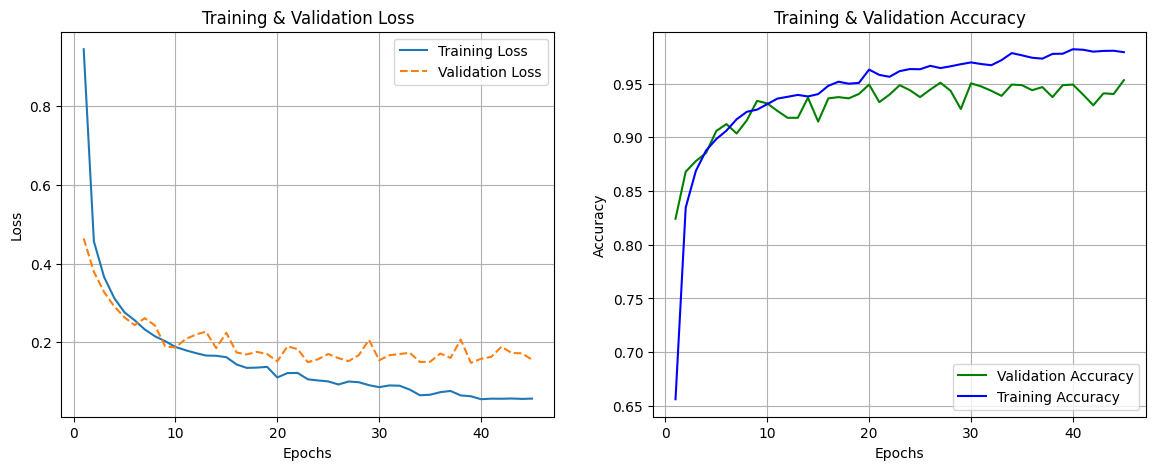


Evaluating on Test Set...
Final Test Loss: 0.1739
Final Test Accuracy: 94.80%


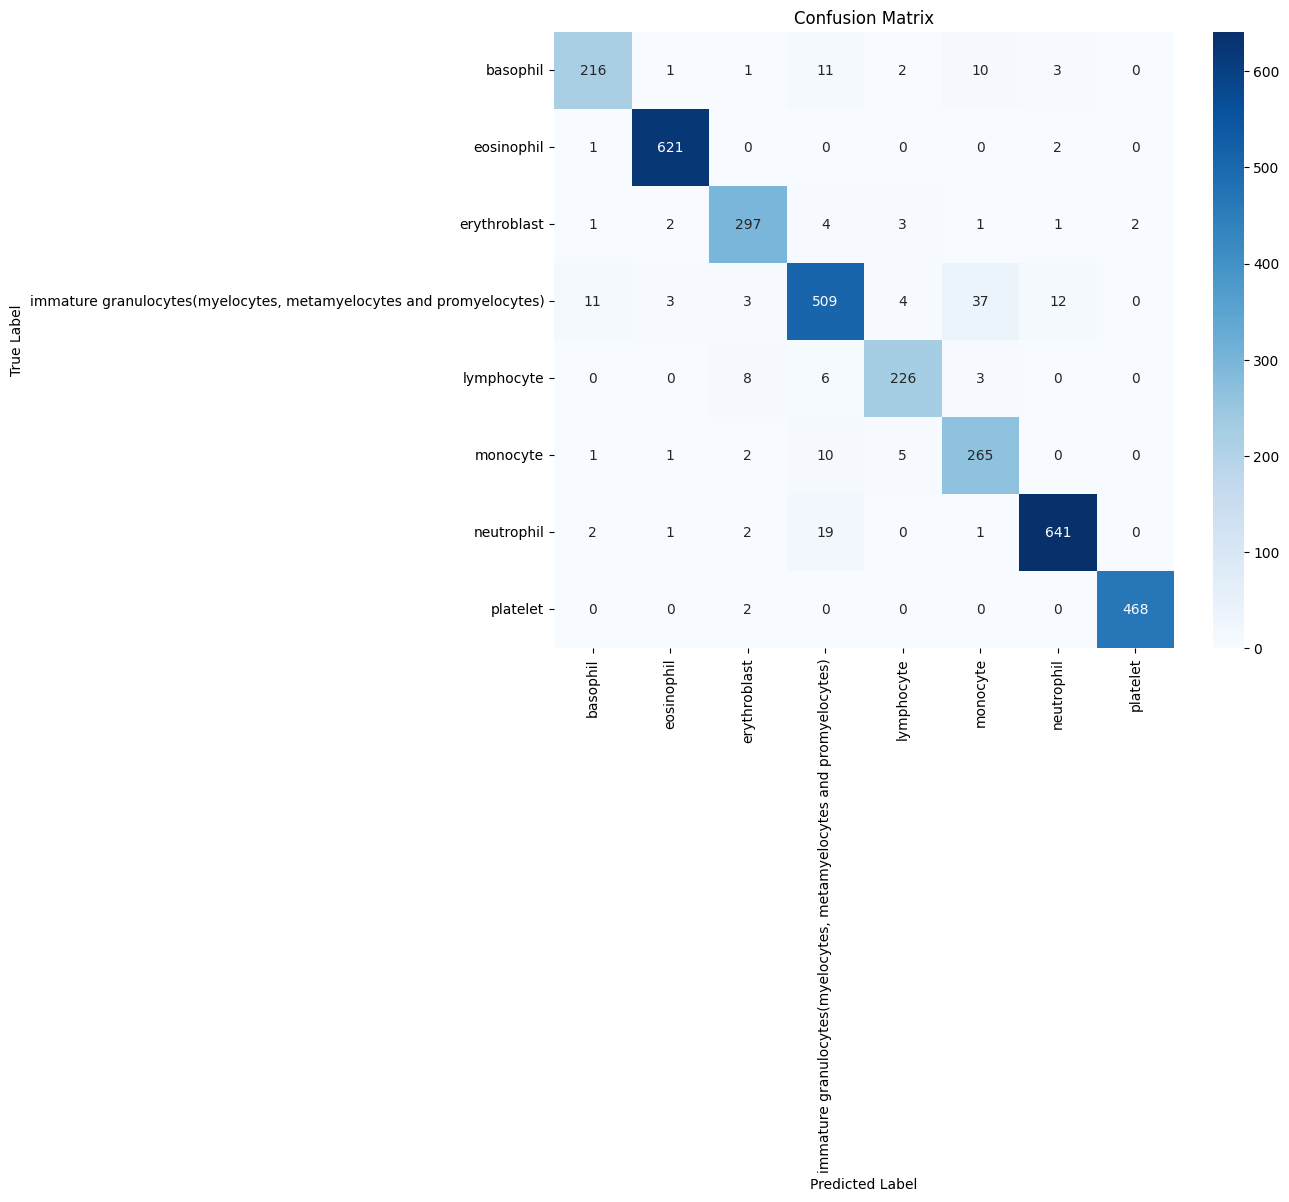


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.93      0.89      0.91       244
                                                         eosinophil       0.99      1.00      0.99       624
                                                       erythroblast       0.94      0.95      0.95       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.91      0.88      0.89       579
                                                         lymphocyte       0.94      0.93      0.94       243
                                                           monocyte       0.84      0.93      0.88       284
                                                         neutrophil       0.97      0.96      0.97       666
                                                           platelet       1.00      1.00      1.00     

In [ ]:
# Hyperparameters

# Seed for reproducibility
torch.manual_seed(42)
# Define epochs
EPOCHS = 45
# Define learning rate
learning_rate = 5e-4

# Initialize optimizer
optimizer = torch.optim.Adam(model_ln.parameters(), lr=learning_rate)
# Define Loss Function
criterion = nn.CrossEntropyLoss()

# Run training
history_ln = run_training(model_ln, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=EPOCHS)
class_names = [labels_map[str(i)] for i in range(8)]
# Evaluate
evaluate_and_visualize(model_ln, test_dataloader, criterion, device, history_ln, class_names)

DROPOUT

In [ ]:
class CNNWithDropout(nn.Module):
    def __init__(self, num_classes=8, drop_percent=0.5):
        super(CNNWithDropout, self).__init__()

        # Input: 28x28 -> Output: 14x14
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Input: 14x14 -> Output: 7x7
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Input: 7x7 -> Output: 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dropout layer
        self.dropout = nn.Dropout(p=drop_percent)

        # Flatten
        self.flatten_dim = 128 * 3 * 3
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        # Flatten
        x = x.flatten(1)

        # Apply Dropout before the final Fully Connected layer
        x = self.dropout(x)

        # Classification
        x = self.fc(x)
        return x

Training with Dropout: 0.2
Starting training on cuda for 35 epochs...
loss: 2.416815  [   64/11959]
loss: 0.307363  [ 6464/11959]
Epoch 1/35 | Train Loss: 0.6291 | Val Loss: 0.3771 | Val Acc: 0.8575
loss: 0.421102  [   64/11959]
loss: 0.293294  [ 6464/11959]
Epoch 2/35 | Train Loss: 0.3482 | Val Loss: 0.4352 | Val Acc: 0.8446
loss: 0.356297  [   64/11959]
loss: 0.283783  [ 6464/11959]
Epoch 3/35 | Train Loss: 0.2791 | Val Loss: 0.2929 | Val Acc: 0.9048
loss: 0.393666  [   64/11959]
loss: 0.146264  [ 6464/11959]
Epoch 4/35 | Train Loss: 0.2468 | Val Loss: 0.2799 | Val Acc: 0.8978
loss: 0.175521  [   64/11959]
loss: 0.129747  [ 6464/11959]
Epoch 5/35 | Train Loss: 0.2145 | Val Loss: 0.2862 | Val Acc: 0.9065
loss: 0.434215  [   64/11959]
loss: 0.232600  [ 6464/11959]
Epoch 6/35 | Train Loss: 0.2112 | Val Loss: 0.2017 | Val Acc: 0.9305
loss: 0.277963  [   64/11959]
loss: 0.390722  [ 6464/11959]
Epoch 7/35 | Train Loss: 0.1876 | Val Loss: 0.2426 | Val Acc: 0.9136
loss: 0.159998  [   64/1195

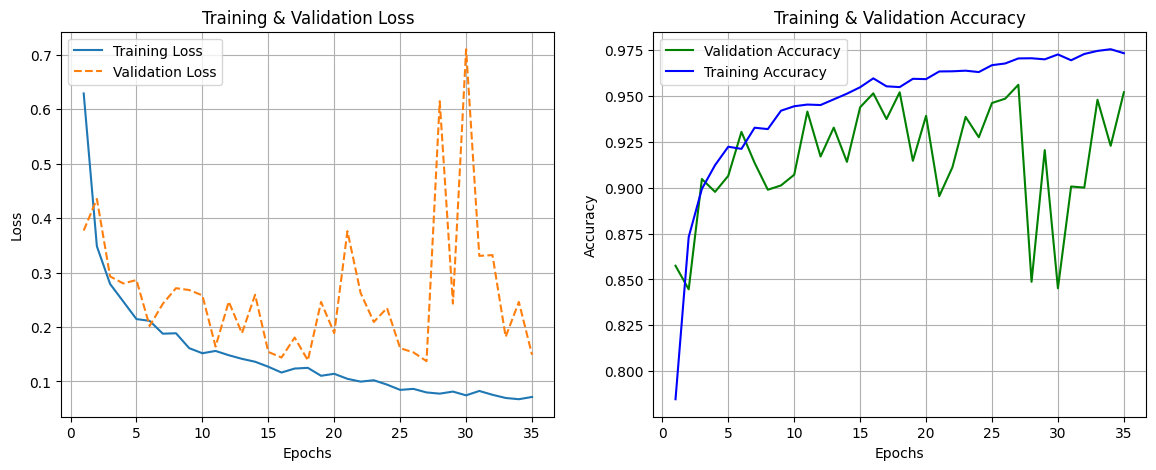


Evaluating on Test Set...
Final Test Loss: 0.1425
Final Test Accuracy: 95.21%


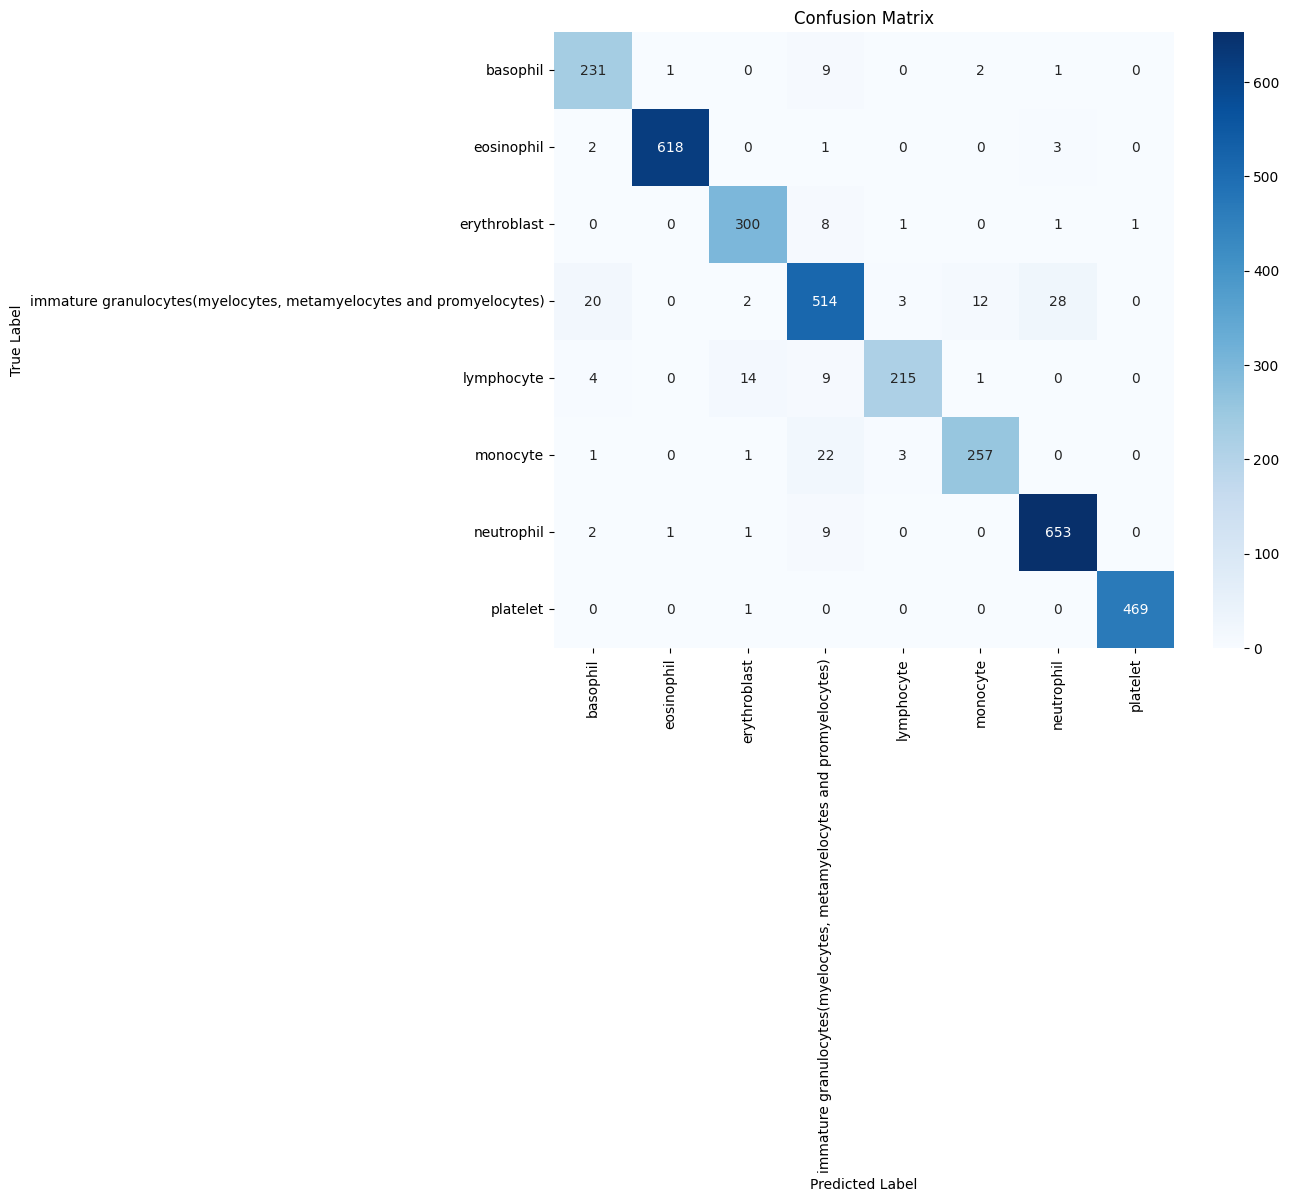


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.89      0.95      0.92       244
                                                         eosinophil       1.00      0.99      0.99       624
                                                       erythroblast       0.94      0.96      0.95       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.90      0.89      0.89       579
                                                         lymphocyte       0.97      0.88      0.92       243
                                                           monocyte       0.94      0.90      0.92       284
                                                         neutrophil       0.95      0.98      0.97       666
                                                           platelet       1.00      1.00      1.00     

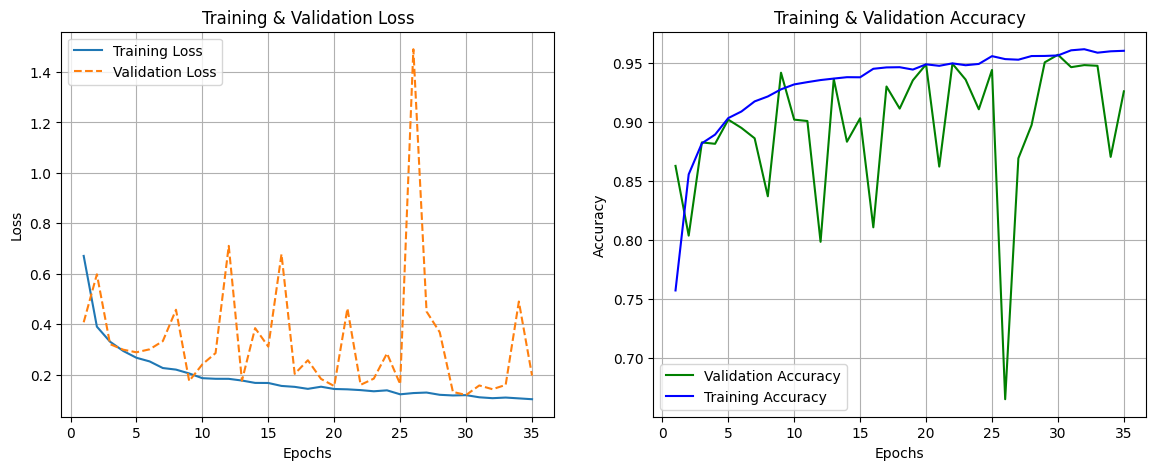


Evaluating on Test Set...
Final Test Loss: 0.2137
Final Test Accuracy: 92.49%


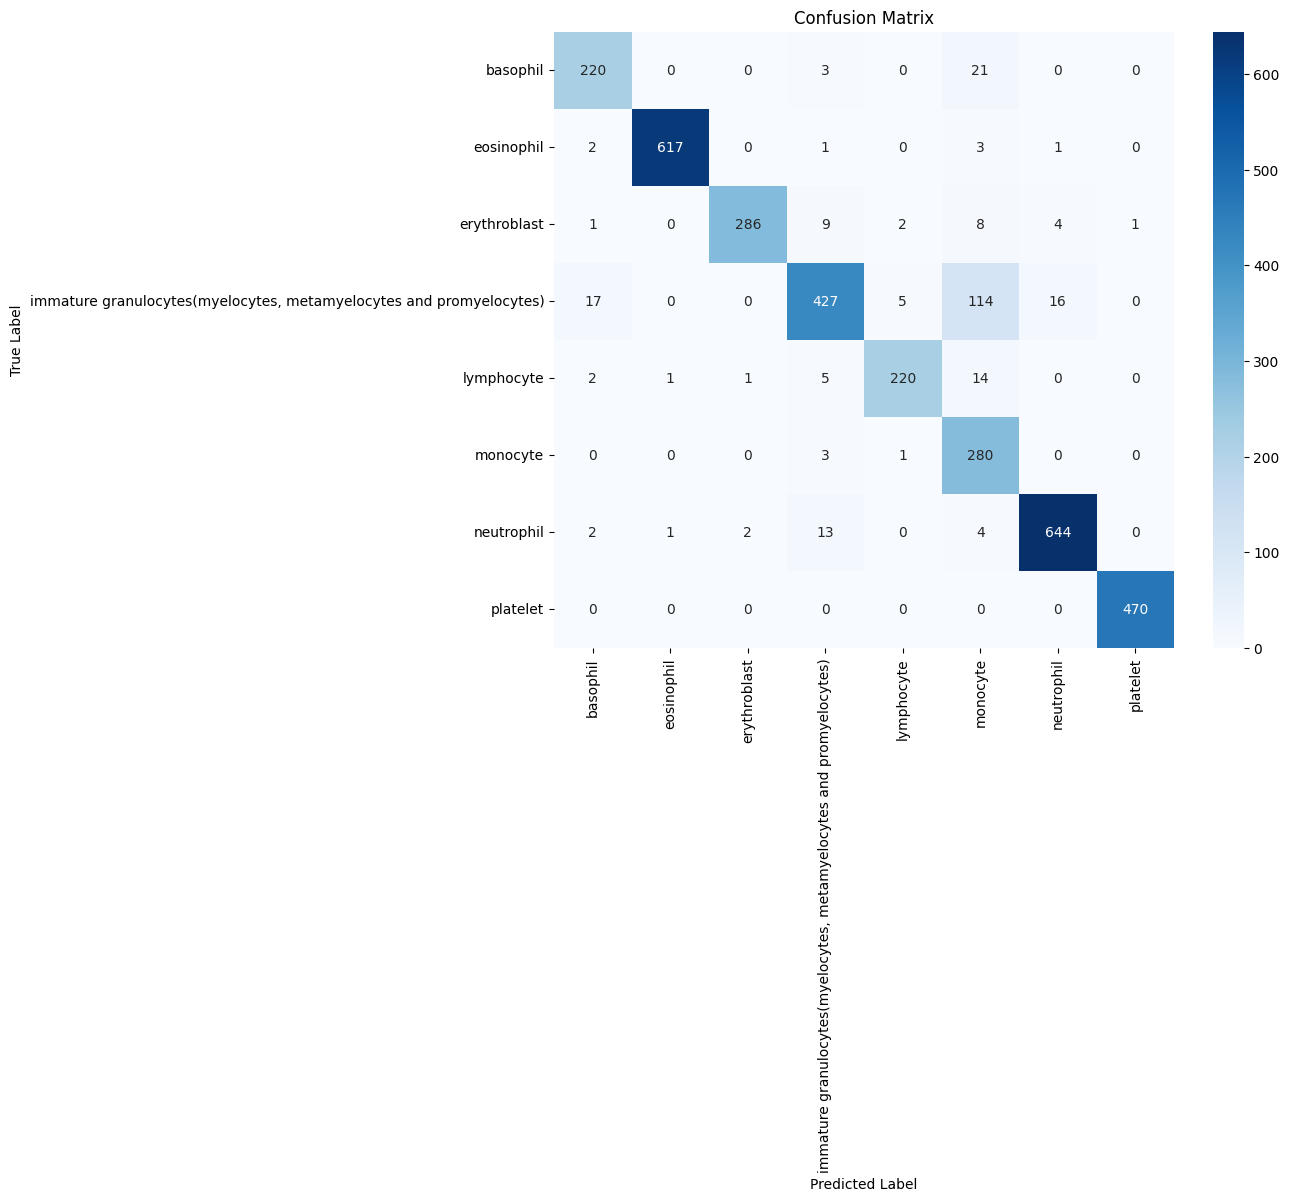


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.90      0.90      0.90       244
                                                         eosinophil       1.00      0.99      0.99       624
                                                       erythroblast       0.99      0.92      0.95       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.93      0.74      0.82       579
                                                         lymphocyte       0.96      0.91      0.93       243
                                                           monocyte       0.63      0.99      0.77       284
                                                         neutrophil       0.97      0.97      0.97       666
                                                           platelet       1.00      1.00      1.00     

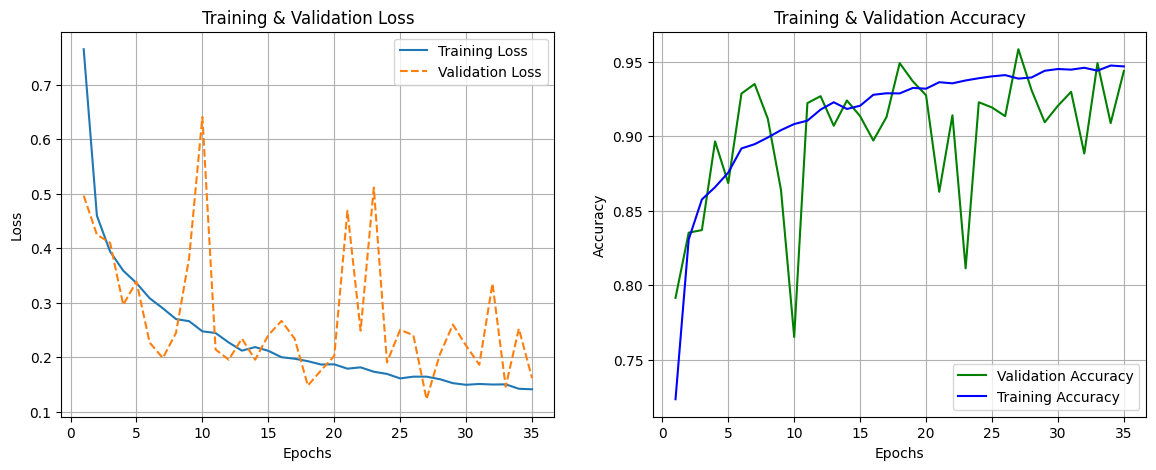


Evaluating on Test Set...
Final Test Loss: 0.2032
Final Test Accuracy: 92.69%


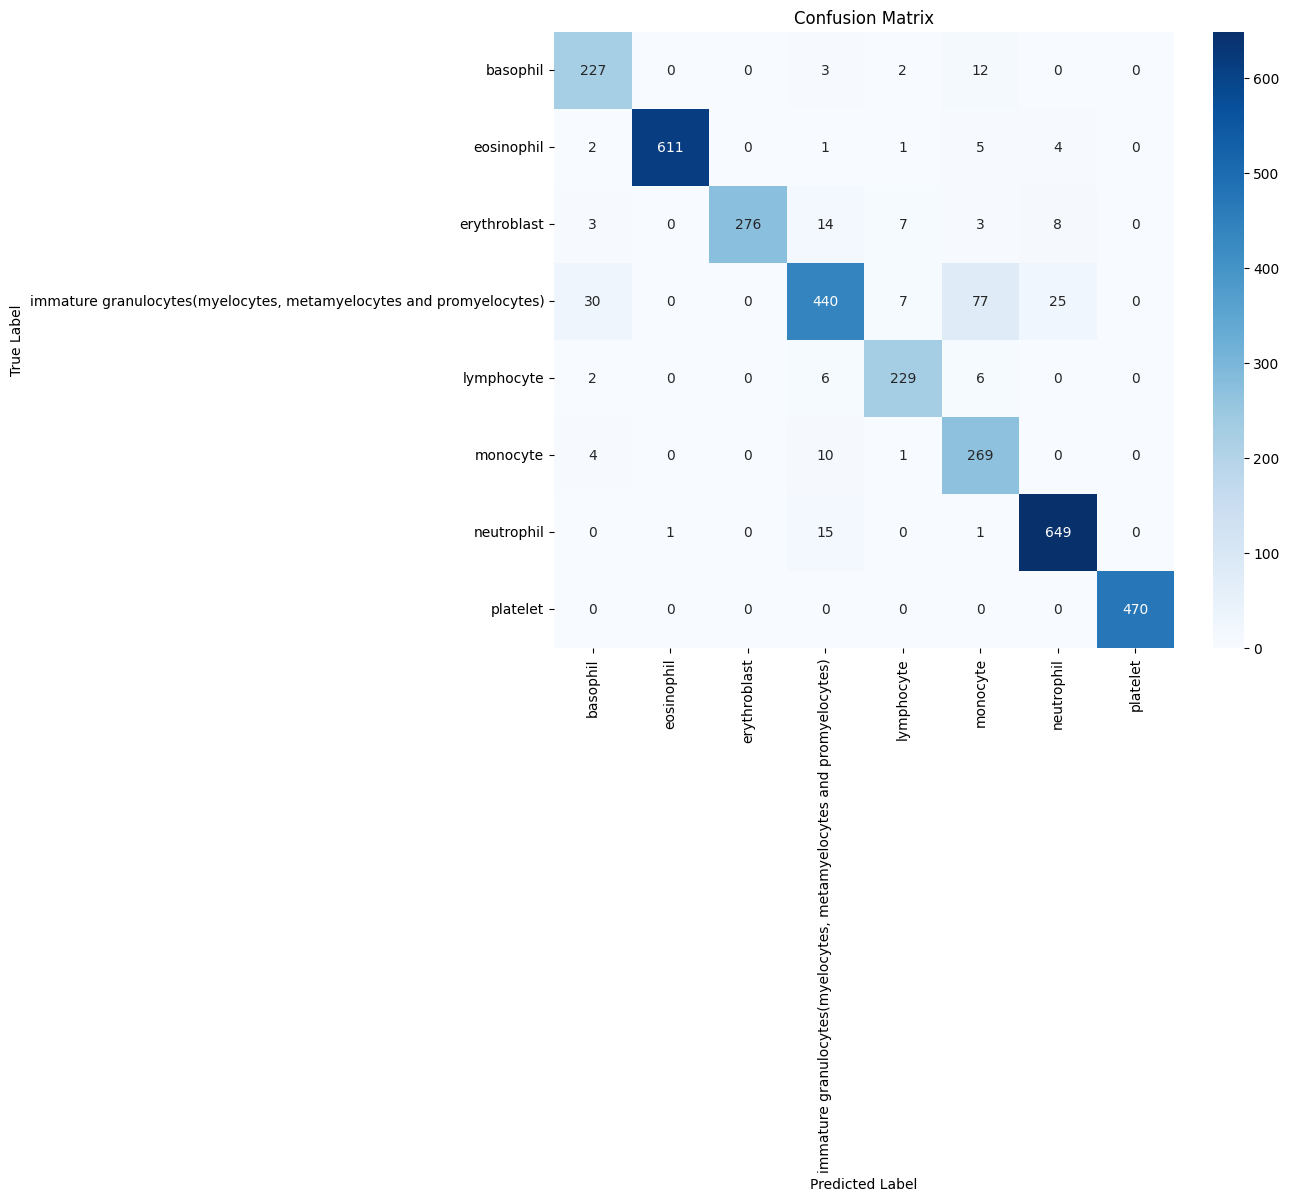


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.85      0.93      0.89       244
                                                         eosinophil       1.00      0.98      0.99       624
                                                       erythroblast       1.00      0.89      0.94       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.90      0.76      0.82       579
                                                         lymphocyte       0.93      0.94      0.93       243
                                                           monocyte       0.72      0.95      0.82       284
                                                         neutrophil       0.95      0.97      0.96       666
                                                           platelet       1.00      1.00      1.00     

In [ ]:
# Transfer the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
# Seed for reproducibility
torch.manual_seed(42)
# Define epochs
EPOCHS = 35
# Define learning rate
learning_rate = 1e-3

# Define list of dropout rates to test
dropout_rates = [0.2, 0.5, 0.7]

# Iterate for each dropout rate
for dp in dropout_rates:
    print(f"Training with Dropout: {dp}")

    # Initialize a new model for each dropout rate
    model_with_dropout = CNNWithDropout(num_classes=8, drop_percent=dp).to(device)

    # Initialize optimizer
    optimizer = torch.optim.Adam(model_with_dropout.parameters(), lr=learning_rate)

    # Define Loss Function
    criterion = nn.CrossEntropyLoss()

    history = run_training(model_with_dropout, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=EPOCHS)
    class_names = [labels_map[str(i)] for i in range(8)]
    evaluate_and_visualize(model_with_dropout, test_dataloader, criterion, device, history, class_names)

WEIGHT DECAY

Training with Weight Decay: 0.0001
Starting training on cuda for 35 epochs...
loss: 2.416815  [   64/11959]
loss: 0.626006  [ 6464/11959]
Epoch 1/35 | Train Loss: 1.0325 | Val Loss: 0.5948 | Val Acc: 0.8195
loss: 0.675614  [   64/11959]
loss: 0.478791  [ 6464/11959]
Epoch 2/35 | Train Loss: 0.5461 | Val Loss: 0.4279 | Val Acc: 0.8470
loss: 0.447764  [   64/11959]
loss: 0.415117  [ 6464/11959]
Epoch 3/35 | Train Loss: 0.4277 | Val Loss: 0.3618 | Val Acc: 0.8843
loss: 0.375985  [   64/11959]
loss: 0.280422  [ 6464/11959]
Epoch 4/35 | Train Loss: 0.3796 | Val Loss: 0.3222 | Val Acc: 0.9001
loss: 0.354700  [   64/11959]
loss: 0.300559  [ 6464/11959]
Epoch 5/35 | Train Loss: 0.3388 | Val Loss: 0.2953 | Val Acc: 0.9065
loss: 0.486178  [   64/11959]
loss: 0.356623  [ 6464/11959]
Epoch 6/35 | Train Loss: 0.3154 | Val Loss: 0.2781 | Val Acc: 0.9106
loss: 0.371530  [   64/11959]
loss: 0.506159  [ 6464/11959]
Epoch 7/35 | Train Loss: 0.2953 | Val Loss: 0.2536 | Val Acc: 0.9200
loss: 0.280765  [  

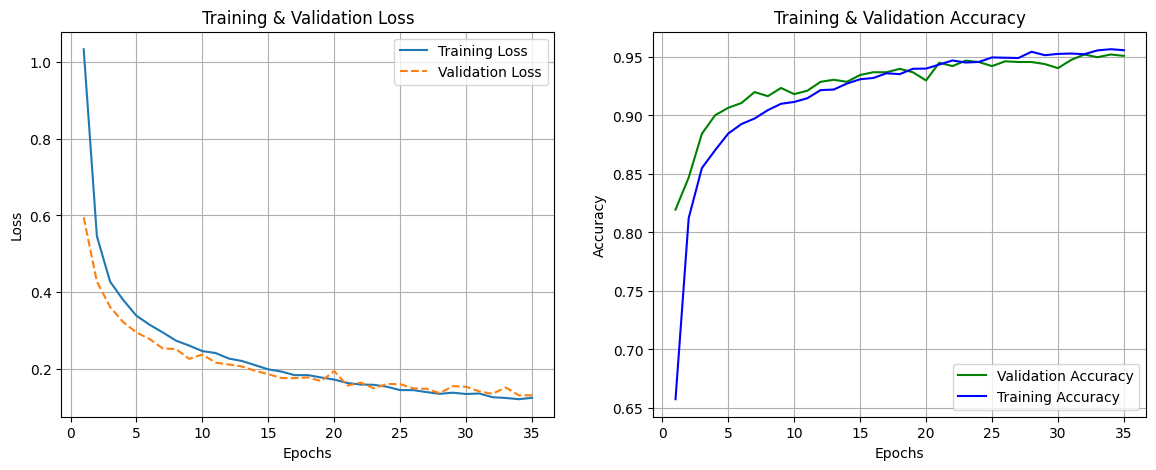


Evaluating on Test Set...
Final Test Loss: 0.1389
Final Test Accuracy: 95.41%


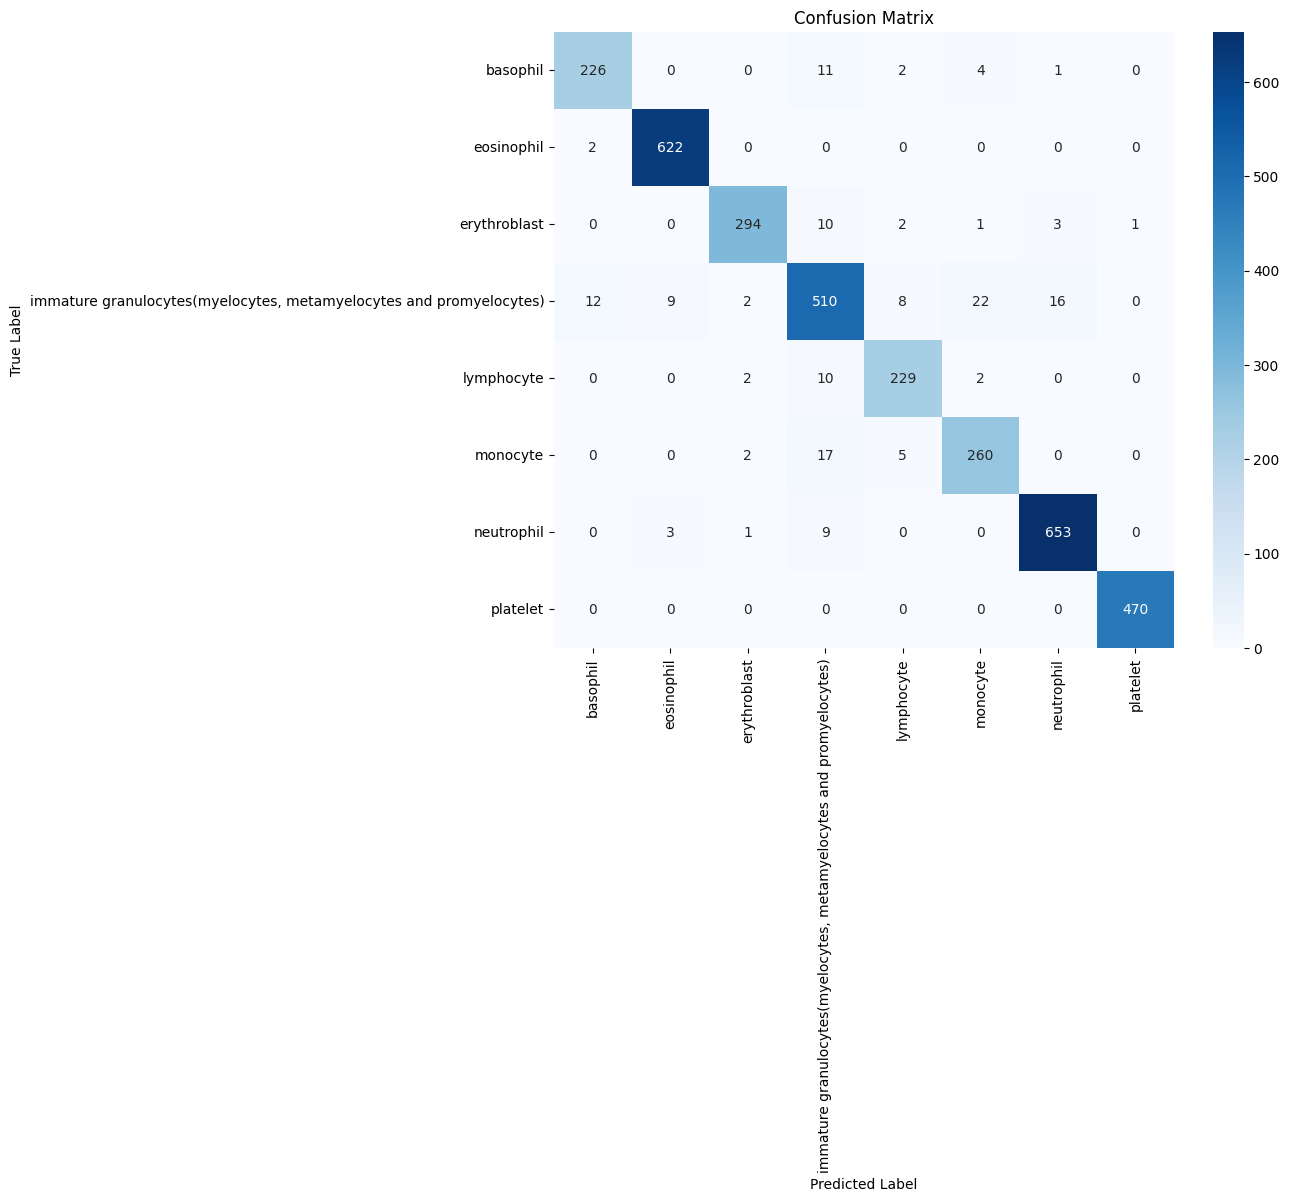


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.94      0.93      0.93       244
                                                         eosinophil       0.98      1.00      0.99       624
                                                       erythroblast       0.98      0.95      0.96       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.90      0.88      0.89       579
                                                         lymphocyte       0.93      0.94      0.94       243
                                                           monocyte       0.90      0.92      0.91       284
                                                         neutrophil       0.97      0.98      0.98       666
                                                           platelet       1.00      1.00      1.00     

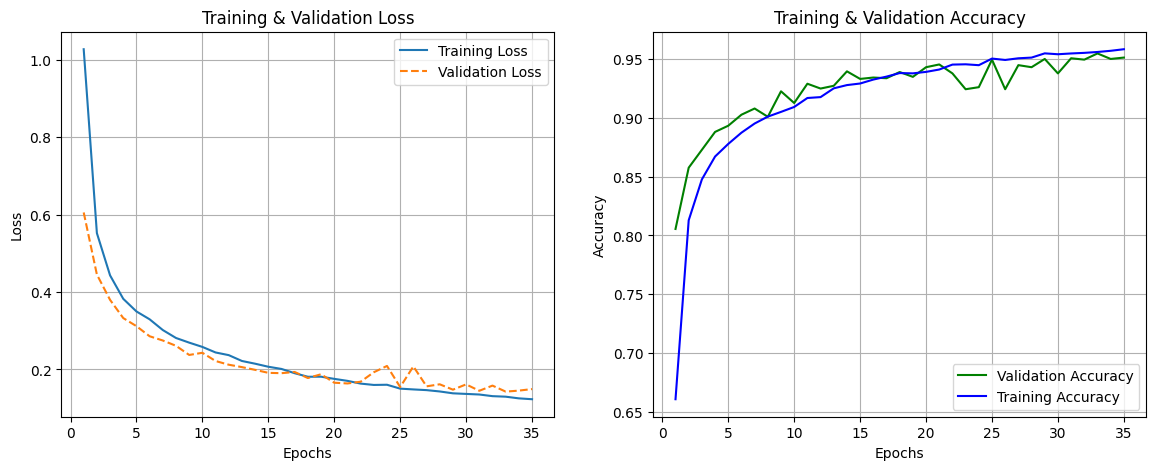


Evaluating on Test Set...
Final Test Loss: 0.1469
Final Test Accuracy: 95.35%


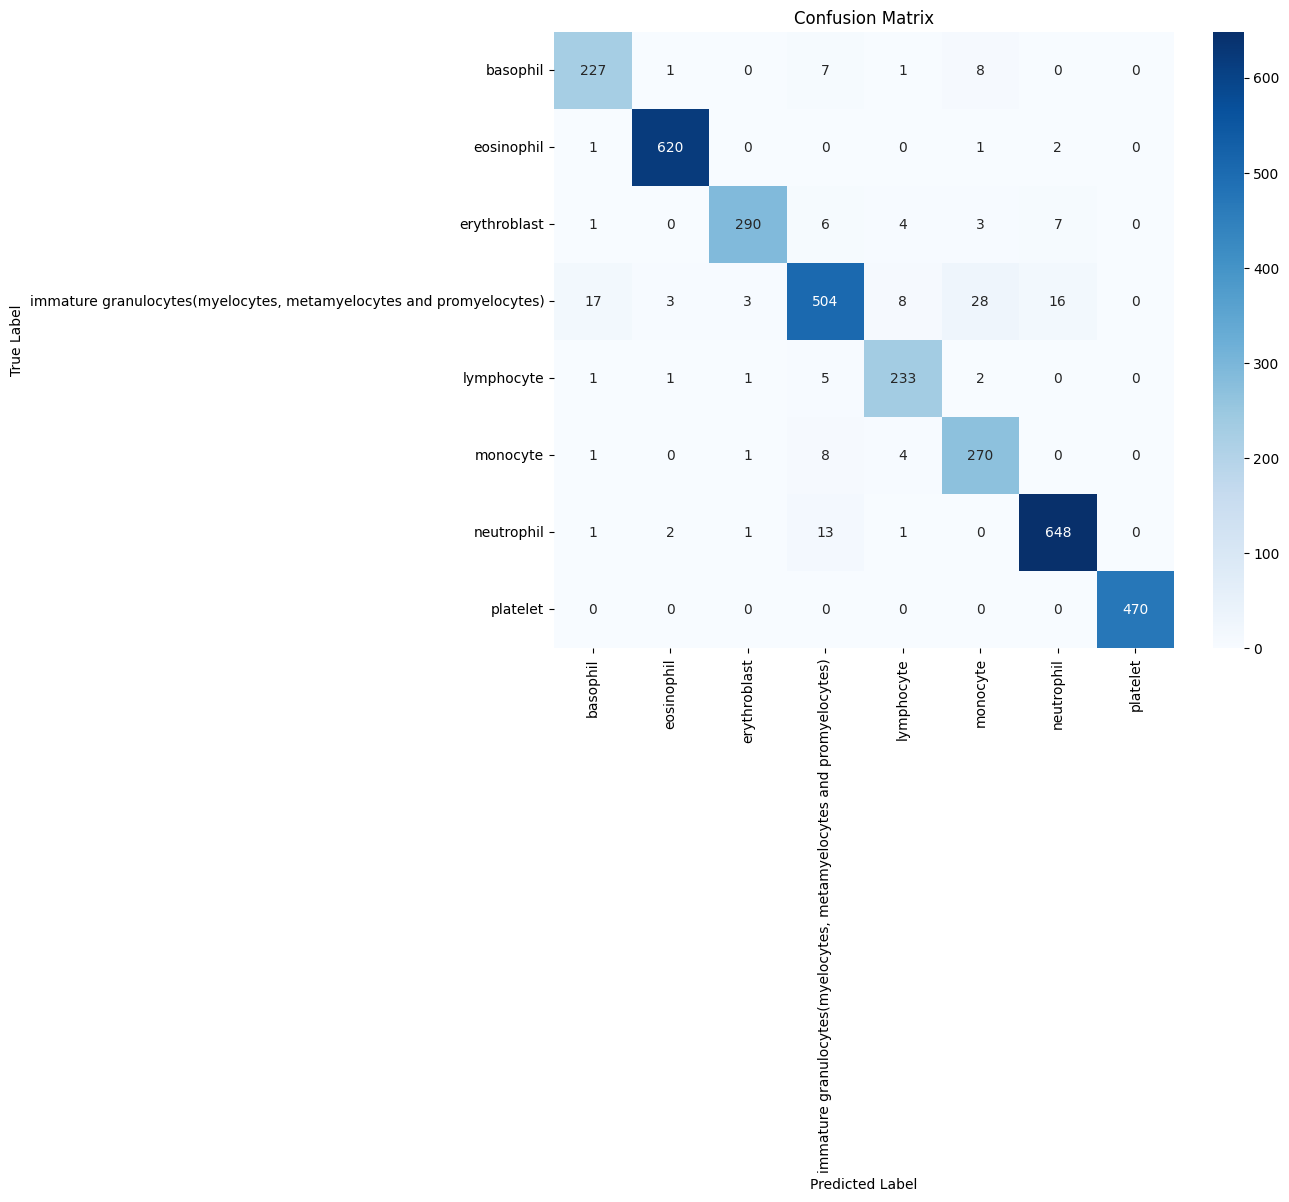


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.91      0.93      0.92       244
                                                         eosinophil       0.99      0.99      0.99       624
                                                       erythroblast       0.98      0.93      0.96       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.93      0.87      0.90       579
                                                         lymphocyte       0.93      0.96      0.94       243
                                                           monocyte       0.87      0.95      0.91       284
                                                         neutrophil       0.96      0.97      0.97       666
                                                           platelet       1.00      1.00      1.00     

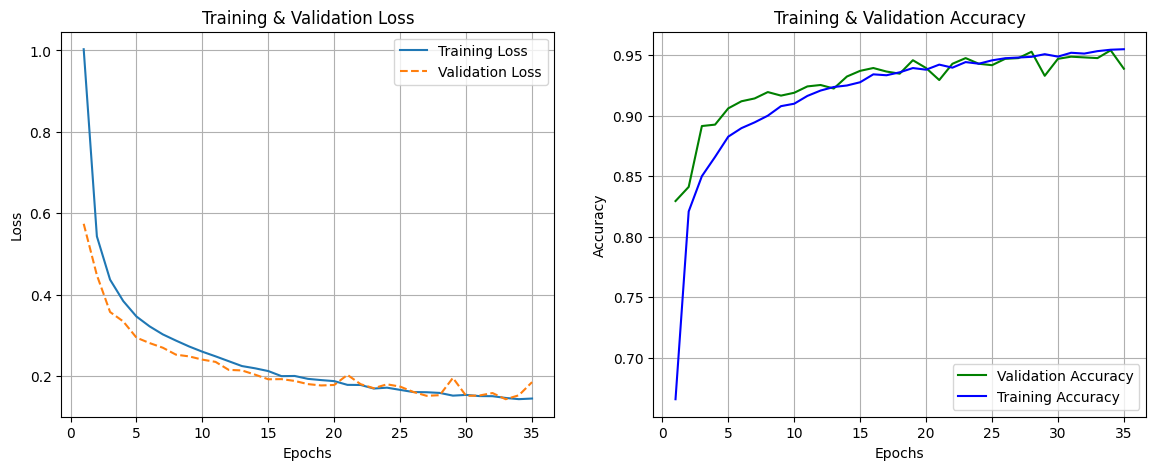


Evaluating on Test Set...
Final Test Loss: 0.1971
Final Test Accuracy: 92.75%


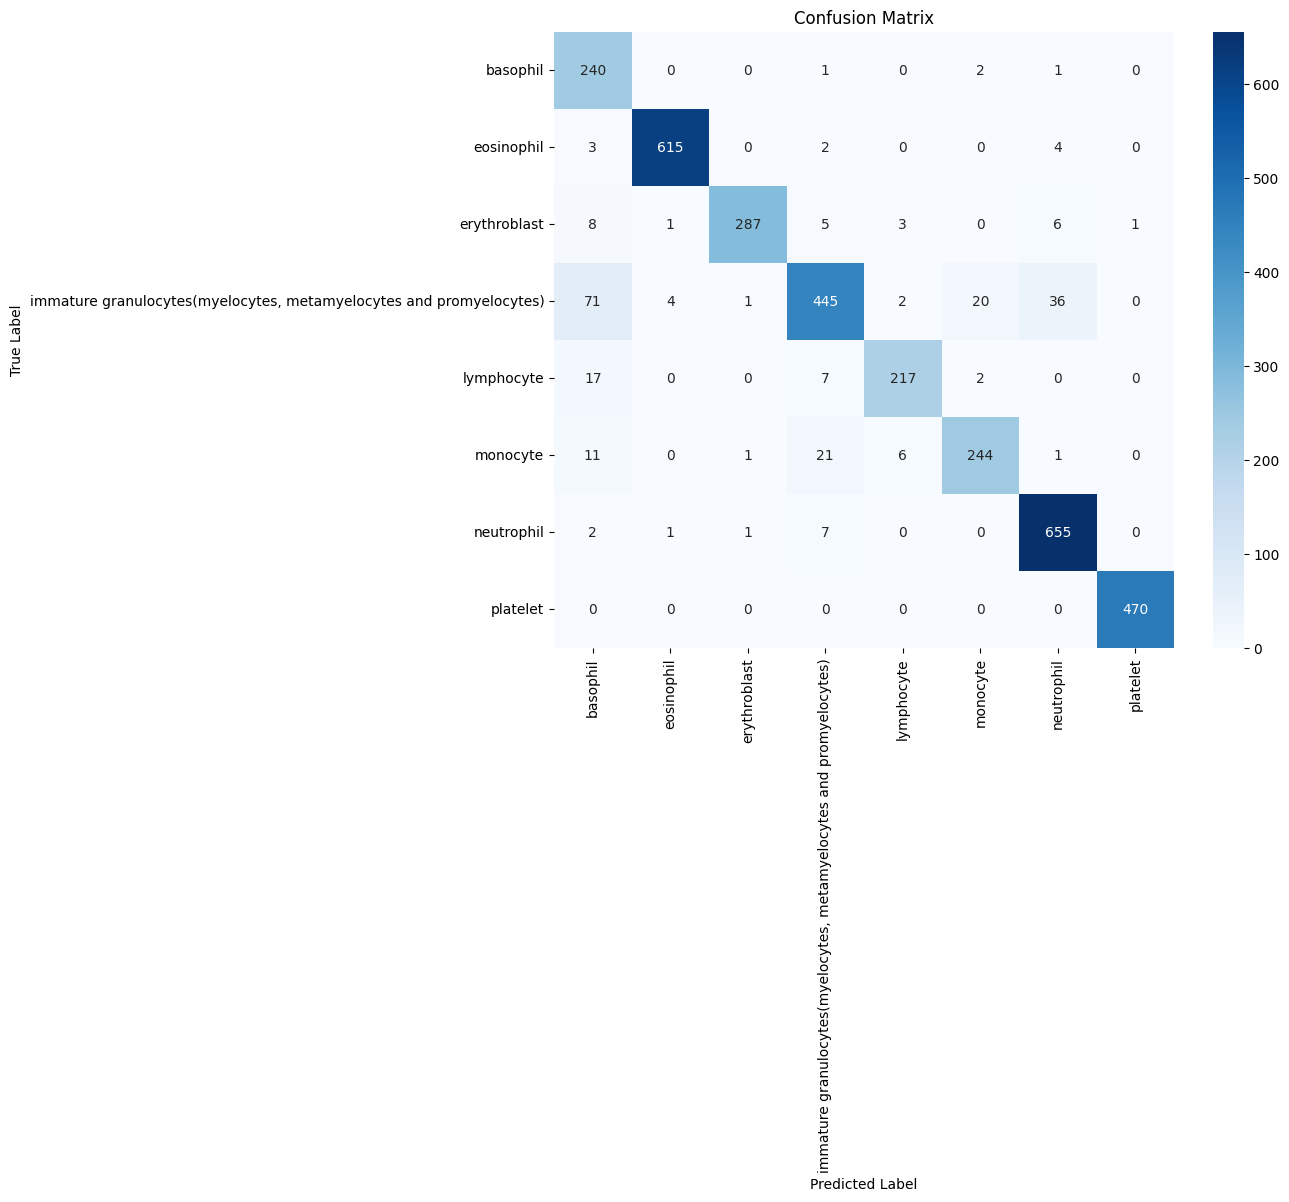


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.68      0.98      0.81       244
                                                         eosinophil       0.99      0.99      0.99       624
                                                       erythroblast       0.99      0.92      0.96       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.91      0.77      0.83       579
                                                         lymphocyte       0.95      0.89      0.92       243
                                                           monocyte       0.91      0.86      0.88       284
                                                         neutrophil       0.93      0.98      0.96       666
                                                           platelet       1.00      1.00      1.00     

In [ ]:
# Transfer the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
# Seed for reproducibility
torch.manual_seed(42)
# Define epochs
EPOCHS = 35
# Define learning rate
learning_rate = 1e-4

# Weight Decay values to test
weight_decay_values = [1e-4, 1e-3, 1e-2]

# Iterate for each Weight Decay value
for wd in weight_decay_values:
    print(f"Training with Weight Decay: {wd}")

    # Initialize model with Dropout Percent = 0.2 (for consistency)
    model_with_weight_decay = CNNWithDropout(num_classes=8, drop_percent=0.2).to(device)

    # Initialize optimizer for this specific Weight Decay value
    optimizer = torch.optim.Adam(
        model_with_weight_decay.parameters(),
        lr=learning_rate,
        weight_decay=wd # Apply Weight Decay in the optimizer
    )

    # Define Loss Function
    criterion = nn.CrossEntropyLoss()

    history = run_training(model_with_weight_decay, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=EPOCHS)
    class_names = [labels_map[str(i)] for i in range(8)]
    evaluate_and_visualize(model_with_weight_decay, test_dataloader, criterion, device, history, class_names)

MIX IT UP

 Training with Learning Rate: 0.0001 
 (Config: LayerNorm, Drop=0.2, WD=0.0001)
Starting training on cuda for 40 epochs...
loss: 2.324642  [   64/11959]
loss: 0.646292  [ 6464/11959]
Epoch 1/40 | Train Loss: 1.0966 | Val Loss: 0.6201 | Val Acc: 0.7786
loss: 0.638687  [   64/11959]
loss: 0.489723  [ 6464/11959]
Epoch 2/40 | Train Loss: 0.5765 | Val Loss: 0.4554 | Val Acc: 0.8382
loss: 0.520272  [   64/11959]
loss: 0.387220  [ 6464/11959]
Epoch 3/40 | Train Loss: 0.4644 | Val Loss: 0.3885 | Val Acc: 0.8662
loss: 0.424976  [   64/11959]
loss: 0.353877  [ 6464/11959]
Epoch 4/40 | Train Loss: 0.4146 | Val Loss: 0.3458 | Val Acc: 0.8832
loss: 0.387672  [   64/11959]
loss: 0.295226  [ 6464/11959]
Epoch 5/40 | Train Loss: 0.3698 | Val Loss: 0.3277 | Val Acc: 0.8896
loss: 0.482234  [   64/11959]
loss: 0.303203  [ 6464/11959]
Epoch 6/40 | Train Loss: 0.3360 | Val Loss: 0.3032 | Val Acc: 0.8972
loss: 0.347890  [   64/11959]
loss: 0.512221  [ 6464/11959]
Epoch 7/40 | Train Loss: 0.3217 | Val Loss:

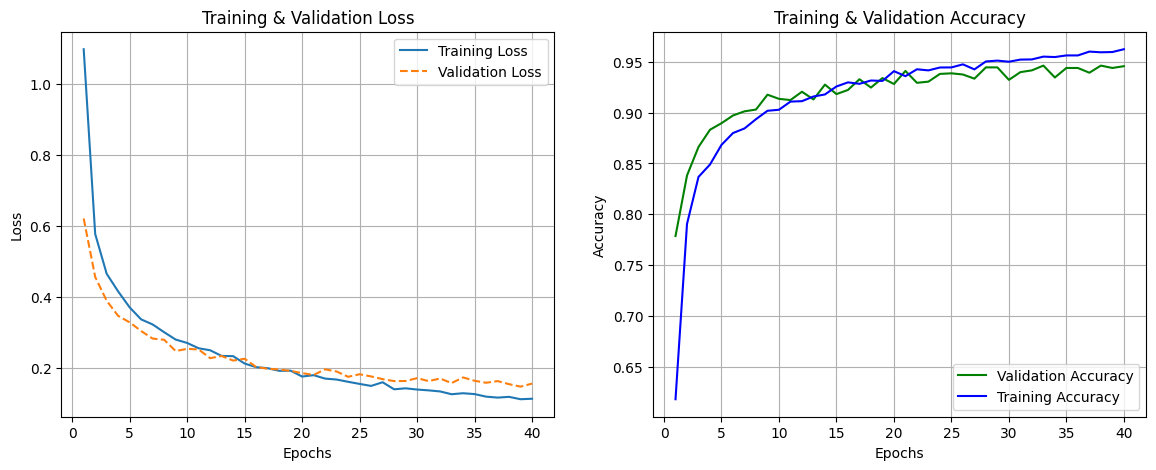


Evaluating on Test Set...
Final Test Loss: 0.1538
Final Test Accuracy: 94.33%


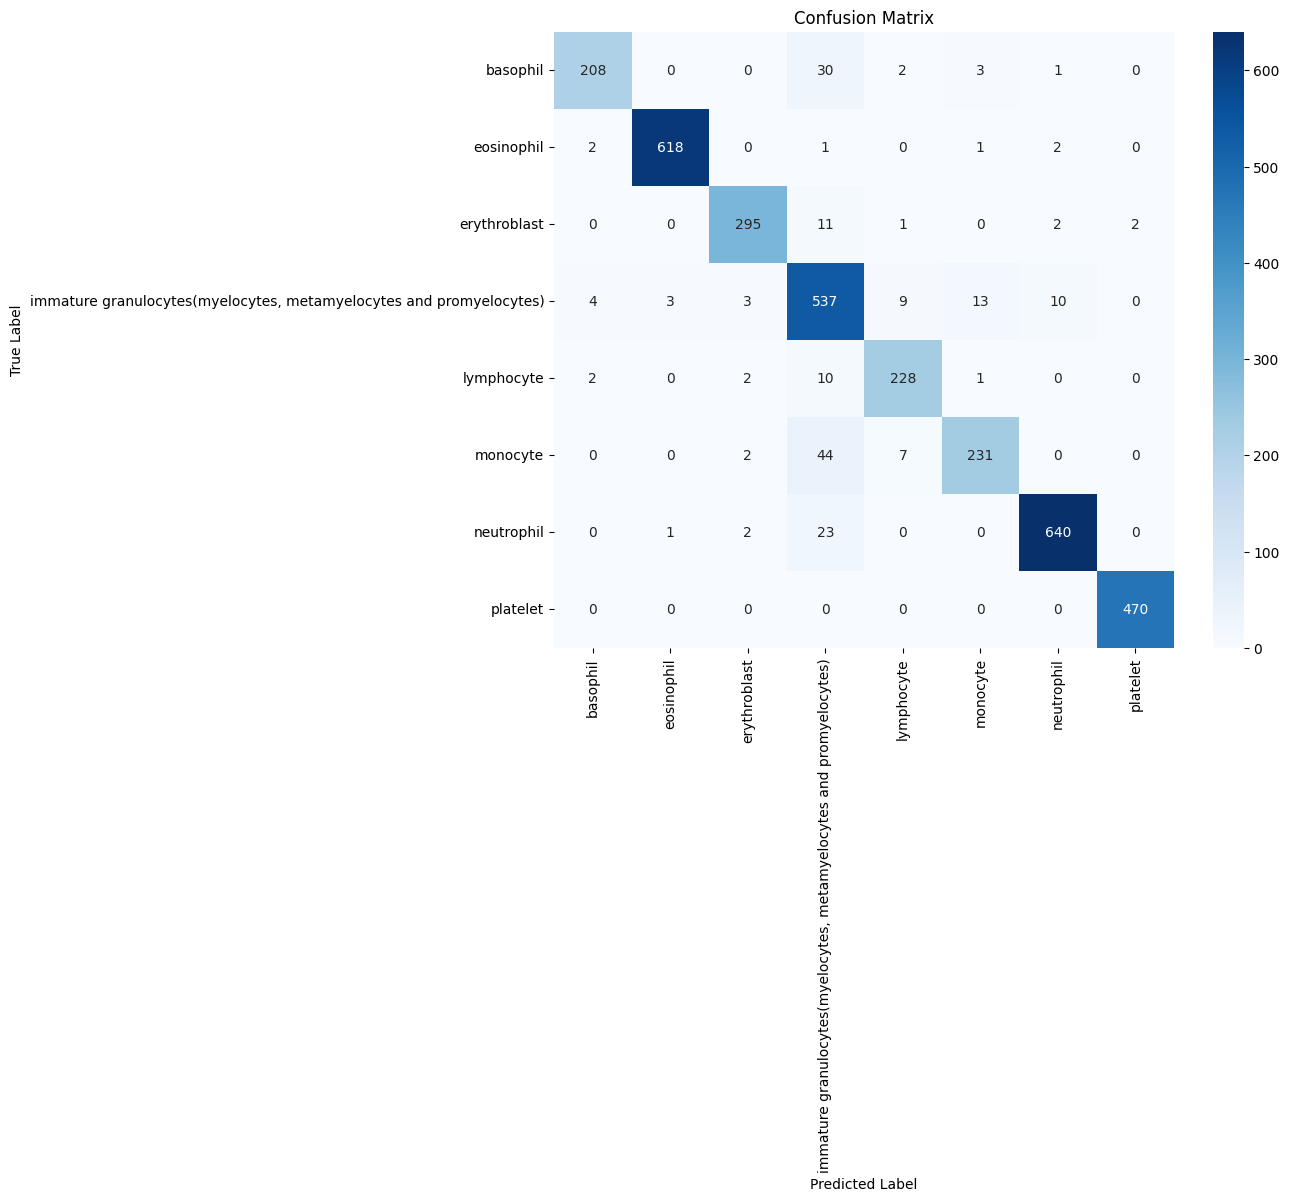


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.96      0.85      0.90       244
                                                         eosinophil       0.99      0.99      0.99       624
                                                       erythroblast       0.97      0.95      0.96       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.82      0.93      0.87       579
                                                         lymphocyte       0.92      0.94      0.93       243
                                                           monocyte       0.93      0.81      0.87       284
                                                         neutrophil       0.98      0.96      0.97       666
                                                           platelet       1.00      1.00      1.00     

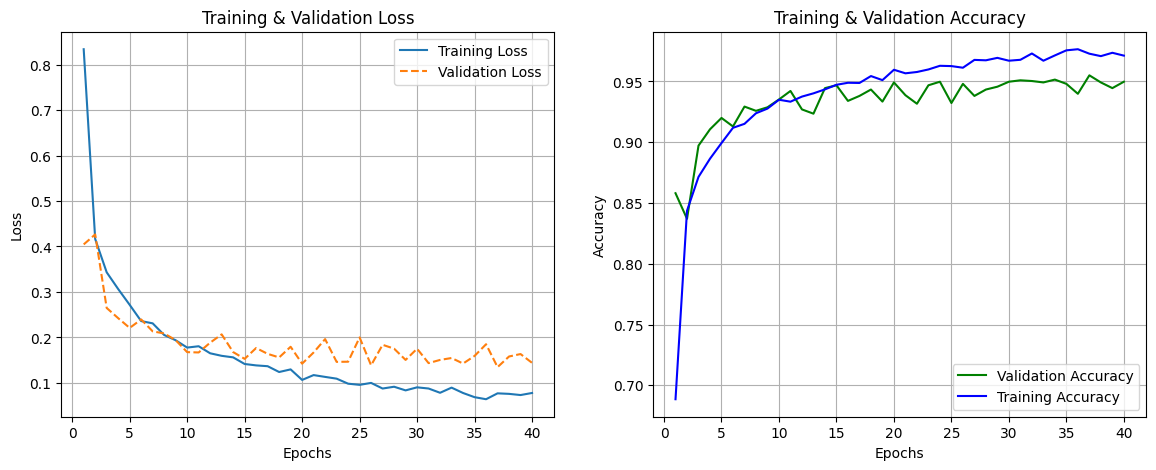


Evaluating on Test Set...
Final Test Loss: 0.1758
Final Test Accuracy: 95.06%


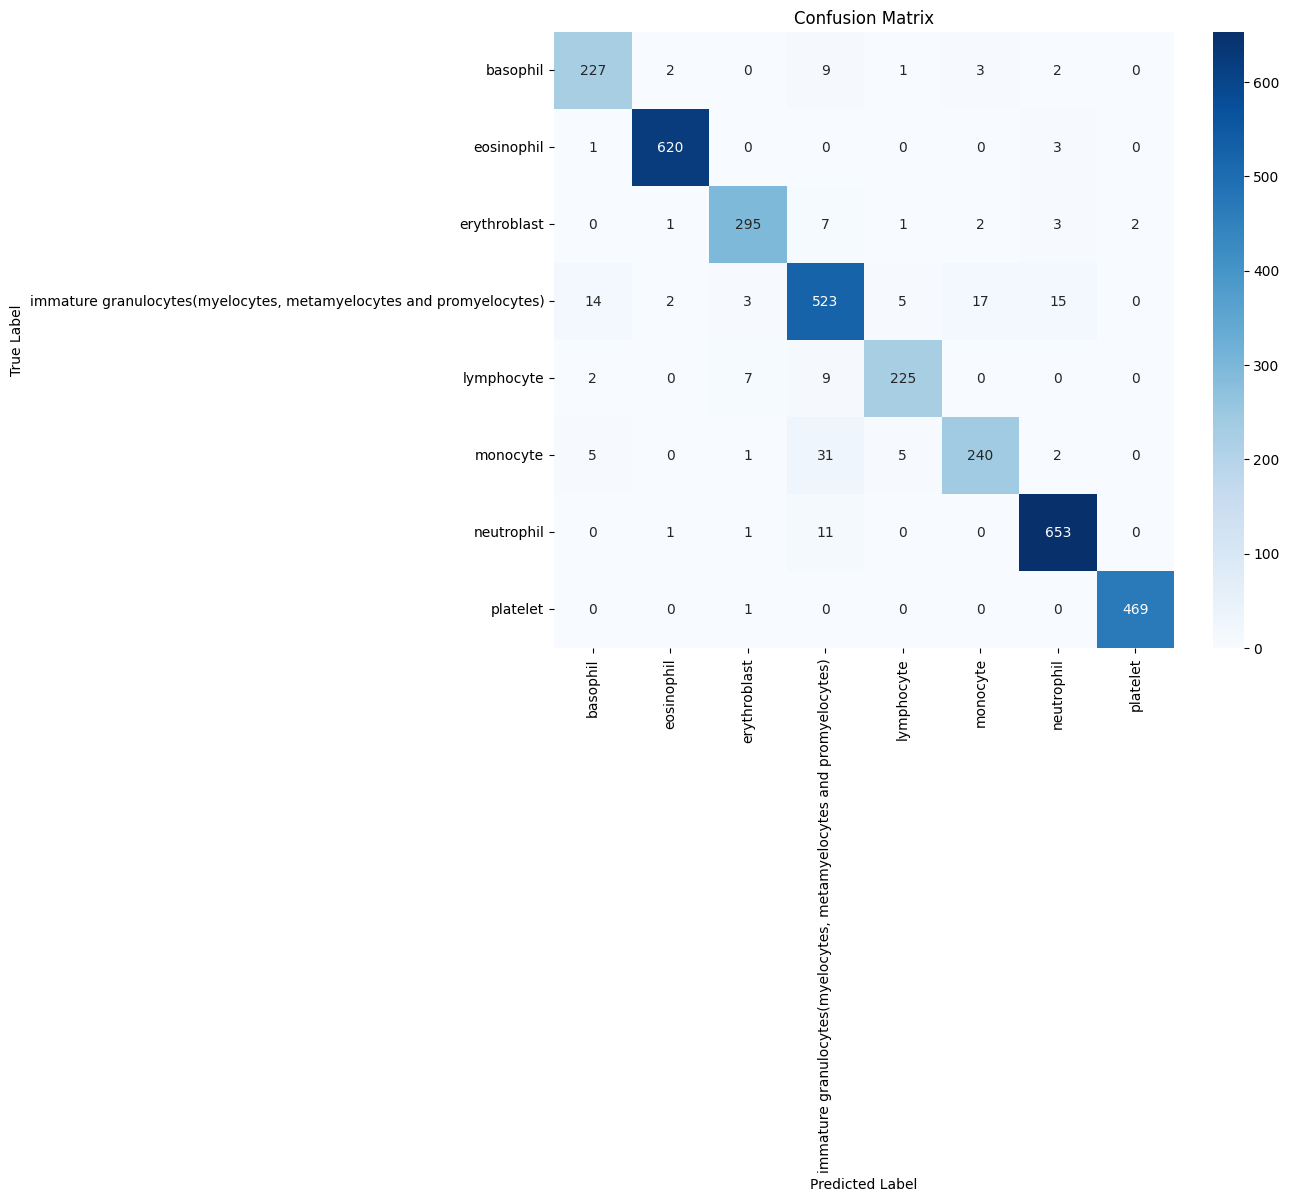


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.91      0.93      0.92       244
                                                         eosinophil       0.99      0.99      0.99       624
                                                       erythroblast       0.96      0.95      0.95       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.89      0.90      0.89       579
                                                         lymphocyte       0.95      0.93      0.94       243
                                                           monocyte       0.92      0.85      0.88       284
                                                         neutrophil       0.96      0.98      0.97       666
                                                           platelet       1.00      1.00      1.00     

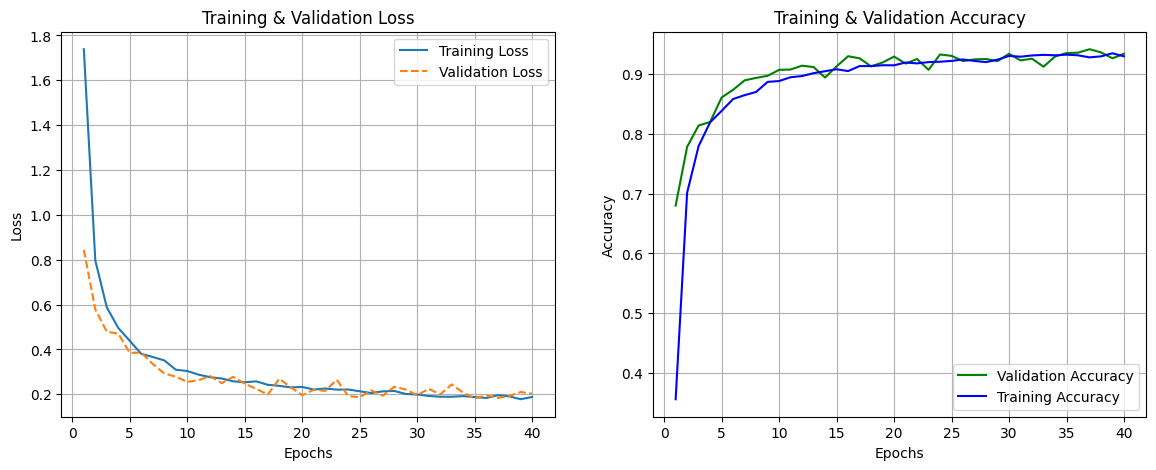


Evaluating on Test Set...
Final Test Loss: 0.2355
Final Test Accuracy: 92.17%


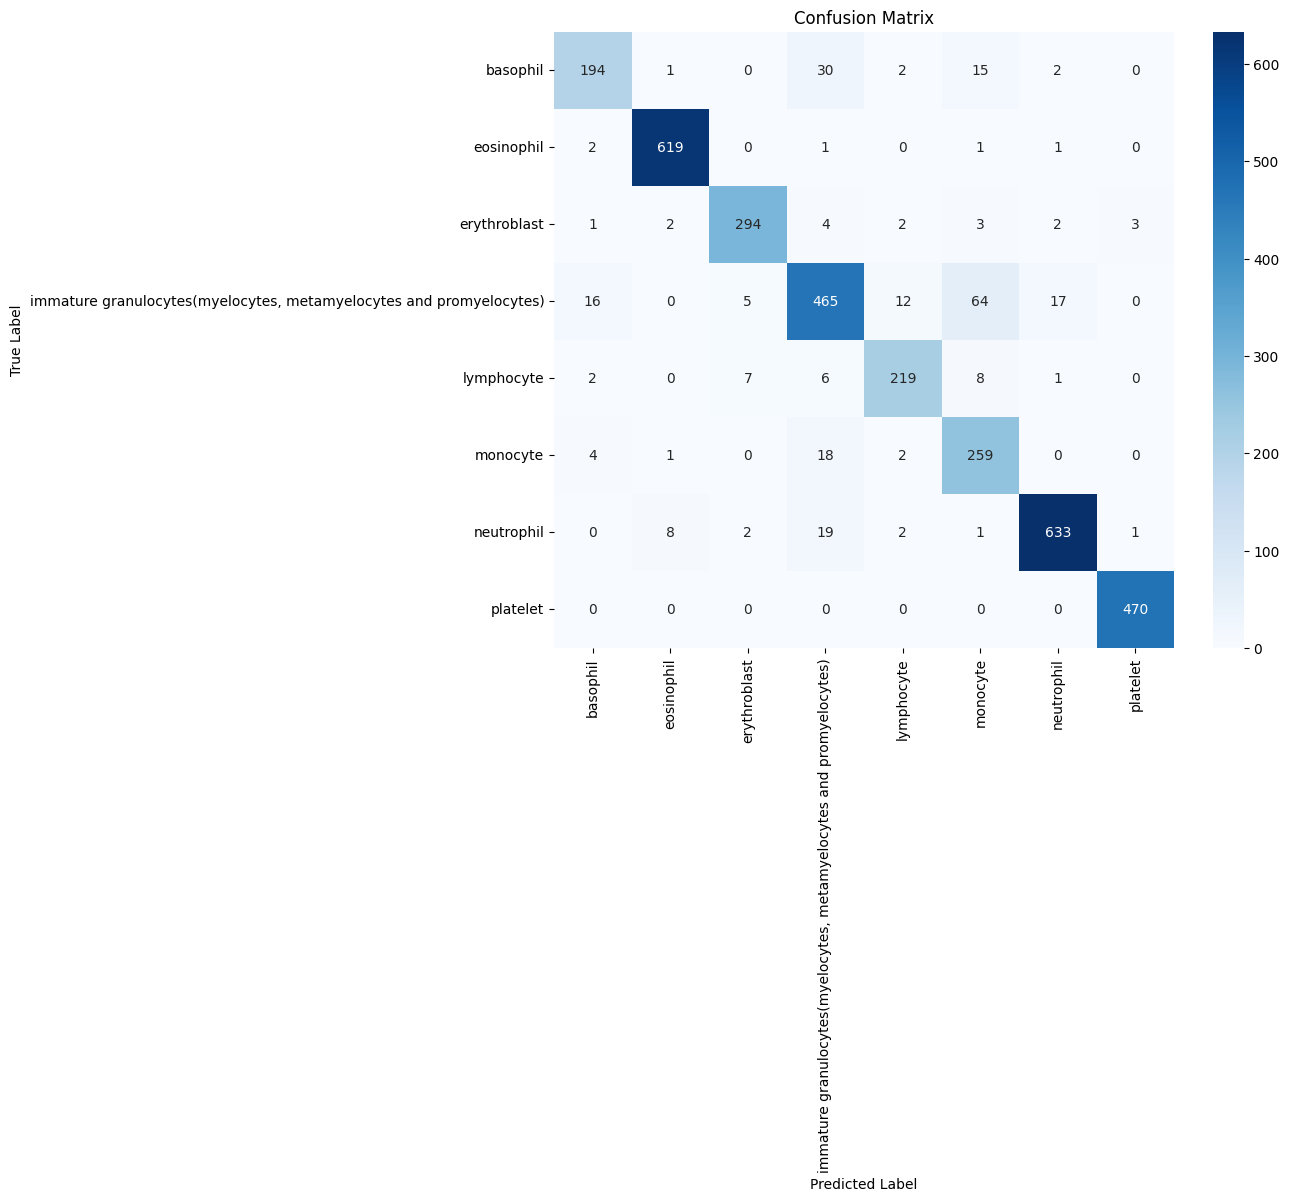


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.89      0.80      0.84       244
                                                         eosinophil       0.98      0.99      0.99       624
                                                       erythroblast       0.95      0.95      0.95       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.86      0.80      0.83       579
                                                         lymphocyte       0.92      0.90      0.91       243
                                                           monocyte       0.74      0.91      0.82       284
                                                         neutrophil       0.96      0.95      0.96       666
                                                           platelet       0.99      1.00      1.00     

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Define the Class with Layer Normalization & Dropout
class CNNLayerNormDropout(nn.Module):
    def __init__(self, num_classes=8, drop_percent=0.2):
        super(CNNLayerNormDropout, self).__init__()

        # Block 1: Conv -> ReLU -> Pool -> LayerNorm
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.ln1 = nn.LayerNorm([32, 14, 14])

        # Block 2: Conv -> ReLU -> Pool -> LayerNorm
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.ln2 = nn.LayerNorm([64, 7, 7])

        # Block 3: Conv -> ReLU -> Pool -> LayerNorm
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.ln3 = nn.LayerNorm([128, 3, 3])

        # Classifier: Flatten -> Dropout -> Linear
        self.flatten_dim = 128 * 3 * 3
        self.fc = nn.Linear(self.flatten_dim, num_classes)
        self.dropout = nn.Dropout(p=drop_percent) # Dropout before the FC layer

    def forward(self, x):
        # Approach: Conv  -> ReLU -> Pool -> LayerNorm
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.ln1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.ln2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.ln3(x)

        x = x.flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42) # Seed for reproducibility

# Fixed parameters for the "Ultimate Combo"
EPOCHS = 40
BEST_WD = 1e-4 # Optimal Weight Decay value from previous experiments
BEST_DROP = 0.2 # Optimal Dropout value from previous experiments

# Learning Rate values to test
learning_rate_values = [1e-4, 1e-3, 5e-3]

# --- Experiment Loop ---
for lr in learning_rate_values:
    print(f" Training with Learning Rate: {lr} ")
    print(f" (Config: LayerNorm, Drop={BEST_DROP}, WD={BEST_WD})")

    # Initialize NEW model in each loop
    model = CNNLayerNormDropout(num_classes=8, drop_percent=BEST_DROP).to(device)

    # Optimizer with current LR and fixed Weight Decay
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=BEST_WD
    )

    # Loss Function
    criterion = nn.CrossEntropyLoss()

    # Training
    history = run_training(model, train_dataloader, val_dataloader, optimizer, criterion, device, epochs=EPOCHS)

    # Evaluation
    print(f"Evaluating LR: {lr}...")
    class_names = [labels_map[str(i)] for i in range(8)]
    evaluate_and_visualize(model, test_dataloader, criterion, device, history, class_names)

# 2. Transfer Learning με CNN

Feature Extraction

In [ ]:
BATCH_SIZE_FE = 64

train_dataloader_fe = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE_FE, shuffle=True)
val_dataloader_fe = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE_FE, shuffle=False)
test_dataloader_fe = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE_FE, shuffle=False)

print("DataLoaders are ready!")

DataLoaders are ready!


In [ ]:
# Load pre-trained ResNet18
feature_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# "Freeze" all parameters of the base model
for param in feature_model.parameters():
    param.requires_grad = False

# Replace the classifier head
num_features = feature_model.fc.in_features # Number of incoming features to the last FC layer
feature_model.fc = nn.Linear(num_features, 8) # New FC layer with 8 outputs

# "Unfreeze" the parameters of the new classifier head
for param in feature_model.fc.parameters():
    param.requires_grad = True

# Transfer the model to the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Starting Feature Extraction
Starting training on cuda for 20 epochs...
loss: 2.124664  [   64/11959]
loss: 1.105527  [ 6464/11959]
Epoch 1/20 | Train Loss: 1.2835 | Val Loss: 1.0802 | Val Acc: 0.6338
loss: 1.241530  [   64/11959]
loss: 1.077707  [ 6464/11959]
Epoch 2/20 | Train Loss: 1.0286 | Val Loss: 0.9777 | Val Acc: 0.6583
loss: 0.849676  [   64/11959]
loss: 0.988647  [ 6464/11959]
Epoch 3/20 | Train Loss: 0.9663 | Val Loss: 0.9248 | Val Acc: 0.6752
loss: 0.852240  [   64/11959]
loss: 0.759441  [ 6464/11959]
Epoch 4/20 | Train Loss: 0.9638 | Val Loss: 0.9218 | Val Acc: 0.6682
loss: 0.932072  [   64/11959]
loss: 1.112508  [ 6464/11959]
Epoch 5/20 | Train Loss: 0.9265 | Val Loss: 0.8894 | Val Acc: 0.6951
loss: 0.825729  [   64/11959]
loss: 1.054144  [ 6464/11959]
Epoch 6/20 | Train Loss: 0.9226 | Val Loss: 0.9014 | Val Acc: 0.6910
loss: 0.885479  [   64/11959]
loss: 1.033820  [ 6464/11959]
Epoch 7/20 | Train Loss: 0.9179 | Val Loss: 0.8981 | Val Acc: 0.6805
loss: 0.871931  [   64/119

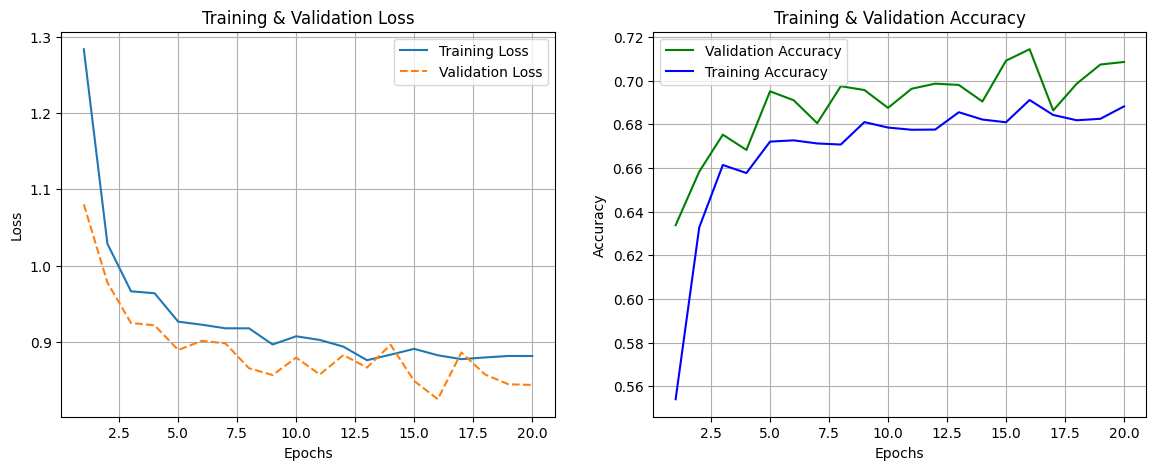


Evaluating on Test Set...
Final Test Loss: 0.8450
Final Test Accuracy: 70.65%


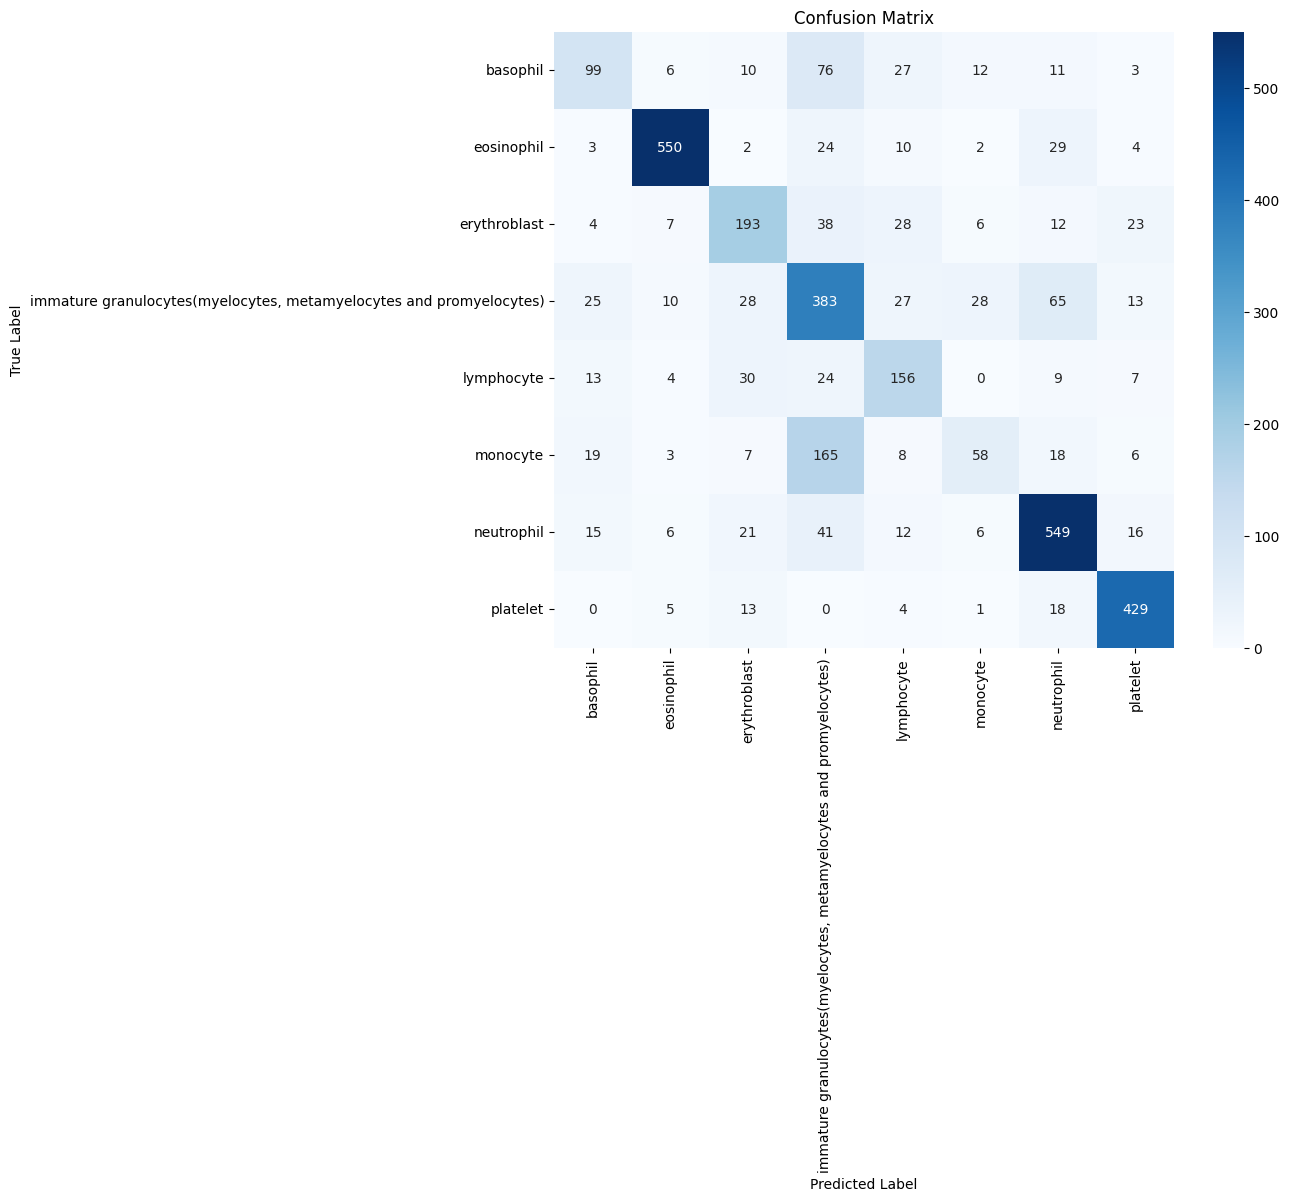


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.56      0.41      0.47       244
                                                         eosinophil       0.93      0.88      0.91       624
                                                       erythroblast       0.63      0.62      0.63       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.51      0.66      0.58       579
                                                         lymphocyte       0.57      0.64      0.61       243
                                                           monocyte       0.51      0.20      0.29       284
                                                         neutrophil       0.77      0.82      0.80       666
                                                           platelet       0.86      0.91      0.88     

In [ ]:
# Hyperparameters
# Seed for reproducibility
torch.manual_seed(42)
# Define epochs
EPOCHS = 20
# Define learning rate
learning_rate = 1e-3

# We choose optimizer only for the trainable (fc) layers.
optimizer = torch.optim.Adam(feature_model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training (Feature Extraction)
print(f"Starting Feature Extraction")
history_fe = run_training(feature_model, train_dataloader_fe, val_dataloader_fe, optimizer, criterion, device, EPOCHS)

class_names = [labels_map[str(i)] for i in range(8)]
evaluate_and_visualize(feature_model, test_dataloader_fe, criterion, device, history_fe, class_names)

Fine Tuning

In [ ]:
BATCH_SIZE_FT = 32 # Smaller batch size for fine-tuning

train_dataloader_fine = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE_FT, shuffle=True)
val_dataloader_fine = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE_FT, shuffle=False)
test_dataloader_fine = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE_FT, shuffle=False)

print("DataLoaders are ready!")

DataLoaders are ready!


In [ ]:
transfer_model = feature_model # Continue with the model trained in Feature Extraction

# "Freeze" all parameters initially
for param in transfer_model.parameters():
    param.requires_grad = False

# "Unfreeze" the last convolutional blocks (e.g., layer3 and layer4 of ResNet)
for param in transfer_model.layer3.parameters():
    param.requires_grad = True
for param in transfer_model.layer4.parameters():
    param.requires_grad = True

# Also, the classifier head must be unfrozen
for param in transfer_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Starting Fine Tuning
Starting training on cuda for 15 epochs...
loss: 0.887099  [   32/11959]
loss: 0.777874  [ 3232/11959]
loss: 0.764974  [ 6432/11959]
loss: 0.616468  [ 9632/11959]
Epoch 1/15 | Train Loss: 0.7305 | Val Loss: 0.4783 | Val Acc: 0.8254
loss: 0.566632  [   32/11959]
loss: 0.596631  [ 3232/11959]
loss: 0.344718  [ 6432/11959]
loss: 0.214479  [ 9632/11959]
Epoch 2/15 | Train Loss: 0.5314 | Val Loss: 0.3679 | Val Acc: 0.8692
loss: 0.485156  [   32/11959]
loss: 0.610676  [ 3232/11959]
loss: 0.821082  [ 6432/11959]
loss: 0.447590  [ 9632/11959]
Epoch 3/15 | Train Loss: 0.4272 | Val Loss: 0.3146 | Val Acc: 0.8949
loss: 0.486054  [   32/11959]
loss: 0.206389  [ 3232/11959]
loss: 0.115032  [ 6432/11959]
loss: 0.476990  [ 9632/11959]
Epoch 4/15 | Train Loss: 0.3716 | Val Loss: 0.2882 | Val Acc: 0.8989
loss: 0.464229  [   32/11959]
loss: 0.370270  [ 3232/11959]
loss: 0.510673  [ 6432/11959]
loss: 0.342053  [ 9632/11959]
Epoch 5/15 | Train Loss: 0.3452 | Val Loss: 0.2658 | Val Acc

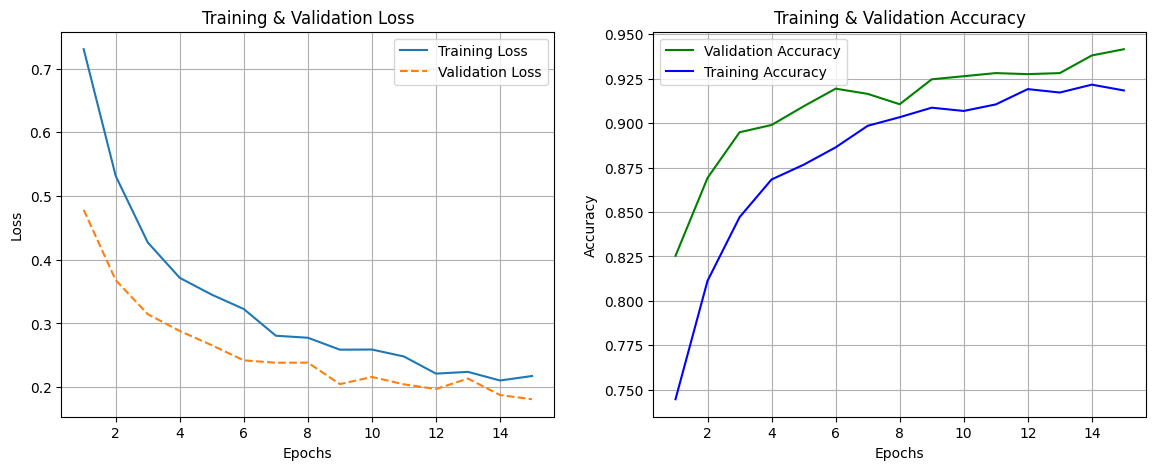


Evaluating on Test Set...
Final Test Loss: 0.2190
Final Test Accuracy: 92.75%


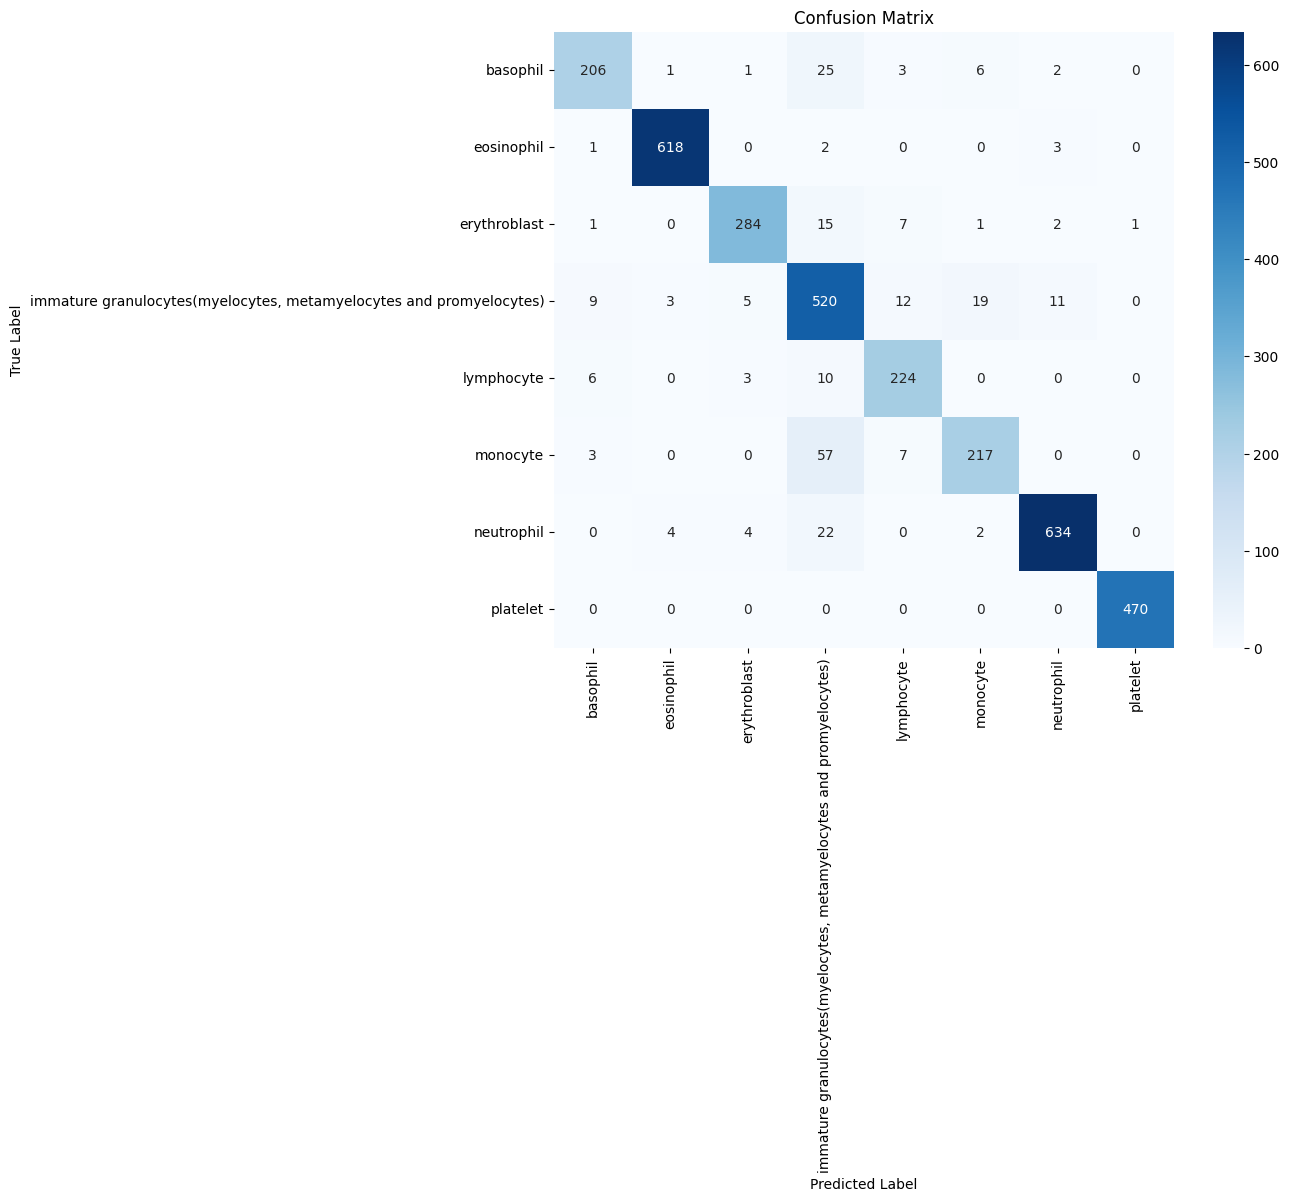


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.91      0.84      0.88       244
                                                         eosinophil       0.99      0.99      0.99       624
                                                       erythroblast       0.96      0.91      0.93       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.80      0.90      0.85       579
                                                         lymphocyte       0.89      0.92      0.90       243
                                                           monocyte       0.89      0.76      0.82       284
                                                         neutrophil       0.97      0.95      0.96       666
                                                           platelet       1.00      1.00      1.00     

In [ ]:
# Hyperparameters
# Seed for reproducibility
torch.manual_seed(42)
# Define epochs
EPOCHS = 15 # Fewer epochs for fine-tuning, as the model is already close to a solution
# Define learning rate
learning_rate = 1e-4

# We choose optimizer only for the parameters that have been set as trainable (requires_grad=True)
optimizer_fine = torch.optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(f"Starting Fine Tuning")
history_tr = run_training(transfer_model, train_dataloader_fine, val_dataloader_fine, optimizer_fine, criterion, device, EPOCHS)

class_names = [labels_map[str(i)] for i in range(8)]
evaluate_and_visualize(transfer_model, test_dataloader_fine, criterion, device, history_tr, class_names)

RESIZE BEFORE

In [ ]:
# 1. Training Transformation (with Data Augmentation)
# Includes Resize to 224x224 and Normalization specifically for ImageNet pre-trained models
train_transform_new = transforms.Compose([
    transforms.Resize(224), # Resize to 224x224 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # 50% probability for horizontal flip
    transforms.RandomRotation(degrees=10),   # Random rotation +/- 10 degrees
    transforms.ToTensor(),                    # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean and standard deviation
                         std=[0.229, 0.224, 0.225]),
])

# 2. Validation & Test Transformation (WITHOUT Augmentation)
# Includes Resize to 224x224 and Normalization
eval_transform_new = transforms.Compose([
    transforms.Resize(224), # Resize to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean and standard deviation
                         std=[0.229, 0.224, 0.225]),
])

# 3. Define Datasets with appropriate transformations
train_dataset = BloodMNIST(
    split='train',
    download=True,
    size=28, # The original dataset is 28x28, but it will be resized with the transform
    transform=train_transform_new
)

val_dataset = BloodMNIST(
    split='val',
    download=True,
    size=28,
    transform=eval_transform_new
)

test_dataset = BloodMNIST(
    split='test',
    download=True,
    size=28,
    transform=eval_transform_new
)

In [ ]:
BATCH_SIZE_FE = 64

train_dataloader_fe2 = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE_FE, shuffle=True)
val_dataloader_fe2 = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE_FE, shuffle=False)
test_dataloader_fe2 = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE_FE, shuffle=False)

print("DataLoaders are ready!")

DataLoaders are ready!


In [ ]:
# Load pre-trained ResNet18
feature_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# "Freeze" all parameters of the base model
for param in feature_model.parameters():
    param.requires_grad = False

# Replace the classifier head for our problem (8 classes)
num_features = feature_model.fc.in_features
feature_model.fc = nn.Linear(num_features, 8)

# "Unfreeze" the parameters of the new classifier head
for param in feature_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Starting Feature Extraction
Starting training on cuda for 20 epochs...
loss: 2.451869  [   64/11959]
loss: 0.775412  [ 6464/11959]
Epoch 1/20 | Train Loss: 1.0618 | Val Loss: 0.7631 | Val Acc: 0.7675
loss: 0.594315  [   64/11959]
loss: 0.620831  [ 6464/11959]
Epoch 2/20 | Train Loss: 0.6225 | Val Loss: 0.6287 | Val Acc: 0.7973
loss: 0.477848  [   64/11959]
loss: 0.542307  [ 6464/11959]
Epoch 3/20 | Train Loss: 0.5485 | Val Loss: 0.5843 | Val Acc: 0.8008
loss: 0.507583  [   64/11959]
loss: 0.401824  [ 6464/11959]
Epoch 4/20 | Train Loss: 0.5094 | Val Loss: 0.5423 | Val Acc: 0.8254
loss: 0.496783  [   64/11959]
loss: 0.459586  [ 6464/11959]
Epoch 5/20 | Train Loss: 0.4896 | Val Loss: 0.5303 | Val Acc: 0.8248
loss: 0.471957  [   64/11959]
loss: 0.522944  [ 6464/11959]
Epoch 6/20 | Train Loss: 0.4693 | Val Loss: 0.5351 | Val Acc: 0.8172
loss: 0.460946  [   64/11959]
loss: 0.446823  [ 6464/11959]
Epoch 7/20 | Train Loss: 0.4594 | Val Loss: 0.5041 | Val Acc: 0.8277
loss: 0.439388  [   64/119

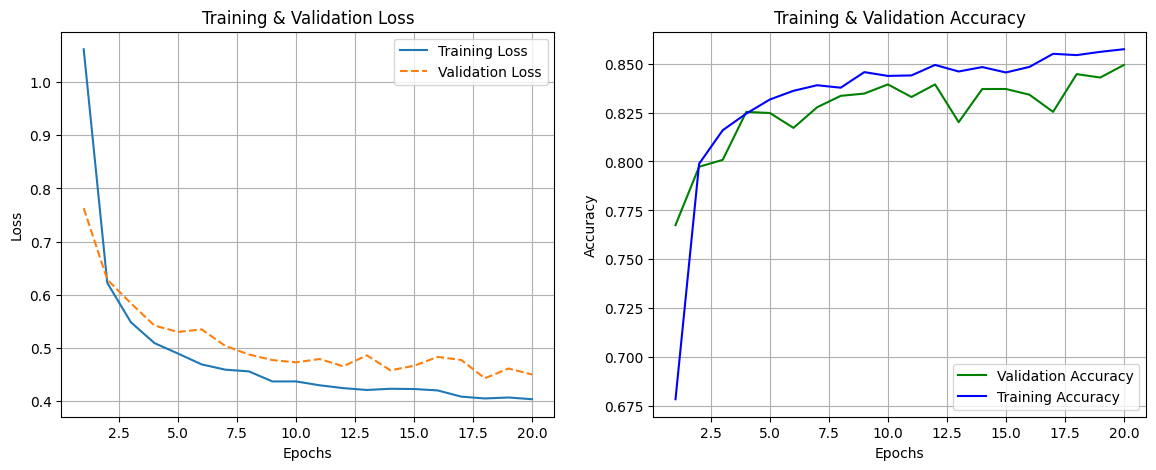


Evaluating on Test Set...
Final Test Loss: 0.4567
Final Test Accuracy: 83.54%


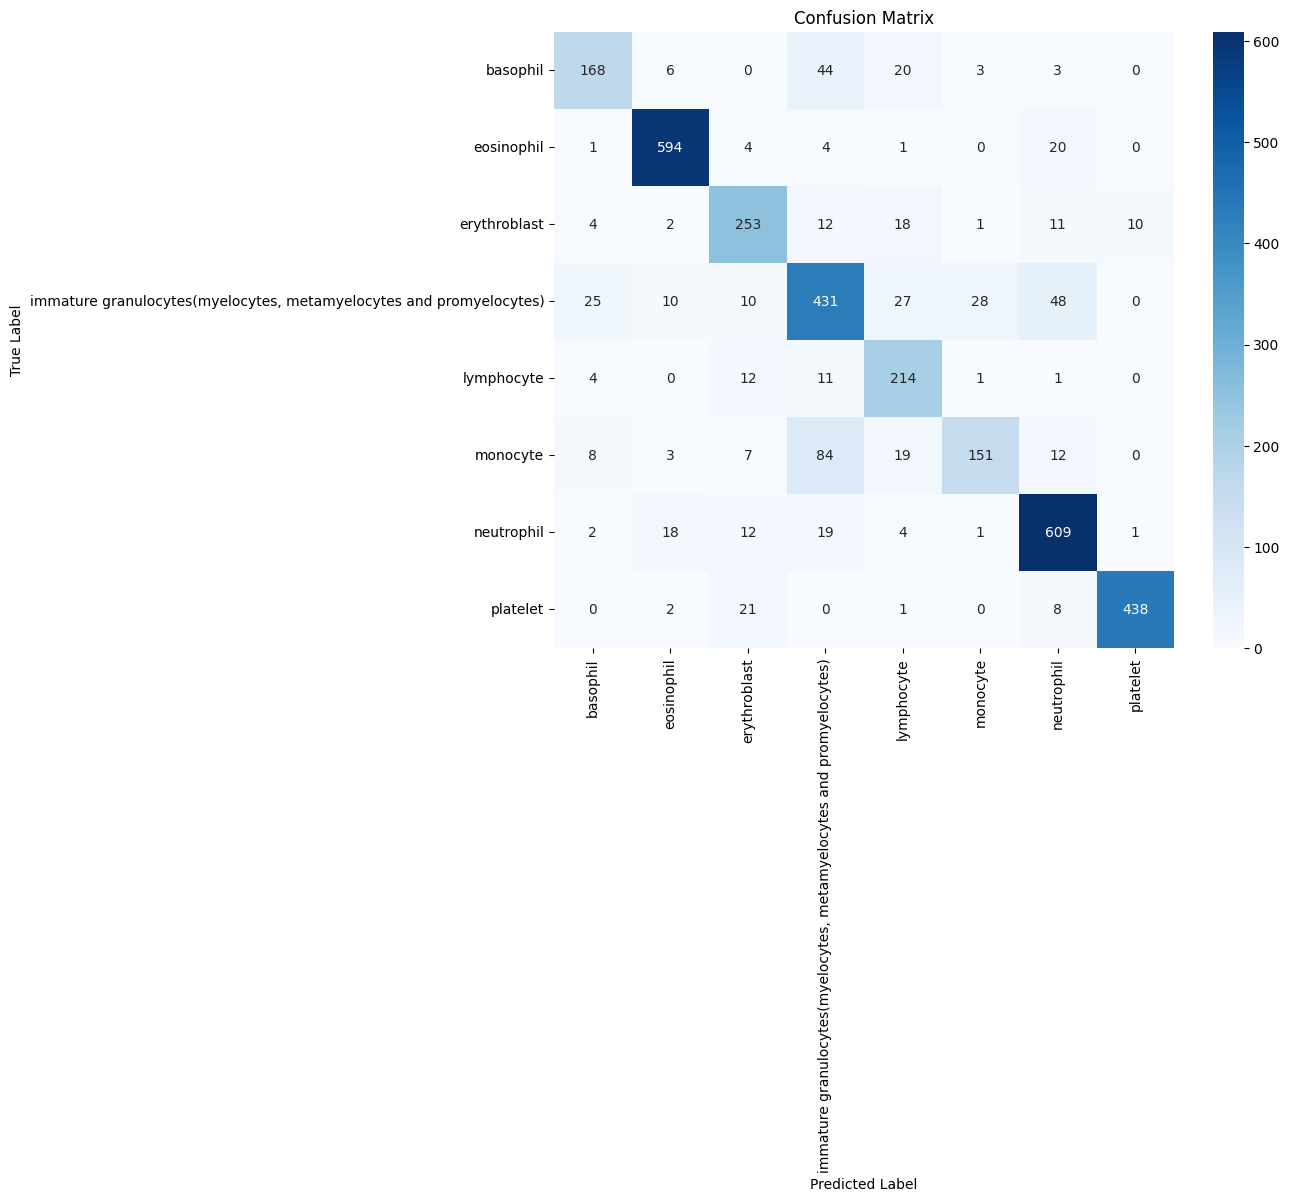


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.79      0.69      0.74       244
                                                         eosinophil       0.94      0.95      0.94       624
                                                       erythroblast       0.79      0.81      0.80       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.71      0.74      0.73       579
                                                         lymphocyte       0.70      0.88      0.78       243
                                                           monocyte       0.82      0.53      0.64       284
                                                         neutrophil       0.86      0.91      0.88       666
                                                           platelet       0.98      0.93      0.95     

In [ ]:
# Hyperparameters
# Seed for reproducibility
torch.manual_seed(42)
# Define epochs
EPOCHS = 20
# Define learning rate
learning_rate = 1e-3

# We choose optimizer only for the trainable (fc) layers.
optimizer = torch.optim.Adam(feature_model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training (Feature Extraction)
print(f"Starting Feature Extraction")
history_fe = run_training(feature_model, train_dataloader_fe2, val_dataloader_fe2, optimizer, criterion, device, EPOCHS)

class_names = [labels_map[str(i)] for i in range(8)]
evaluate_and_visualize(feature_model, test_dataloader_fe2, criterion, device, history_fe, class_names)

In [ ]:
BATCH_SIZE_FT = 32

train_dataloader_fine2 = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE_FT, shuffle=True)
val_dataloader_fine2 = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE_FT, shuffle=False)
test_dataloader_fine2 = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE_FT, shuffle=False)

print("DataLoaders are ready!")

DataLoaders are ready!


In [ ]:
transfer_model = feature_model # Continue with the model trained in Feature Extraction

# "Freeze" all parameters initially
for param in transfer_model.parameters():
    param.requires_grad = False

# "Unfreeze" the last convolutional blocks (e.g., layer3 and layer4 of ResNet)
for param in transfer_model.layer3.parameters():
    param.requires_grad = True
for param in transfer_model.layer4.parameters():
    param.requires_grad = True

# Also, the classifier head must be unfrozen
for param in transfer_model.fc.parameters():
    param.requires_grad = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transfer_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Starting Fine Tuning
Starting training on cuda for 15 epochs...
loss: 0.383994  [   32/11959]
loss: 1.034391  [ 3232/11959]
loss: 0.396497  [ 6432/11959]
loss: 0.140969  [ 9632/11959]
Epoch 1/15 | Train Loss: 0.3168 | Val Loss: 0.2002 | Val Acc: 0.9352
loss: 0.235183  [   32/11959]
loss: 0.349593  [ 3232/11959]
loss: 0.143768  [ 6432/11959]
loss: 0.198498  [ 9632/11959]
Epoch 2/15 | Train Loss: 0.1842 | Val Loss: 0.1525 | Val Acc: 0.9398
loss: 0.095443  [   32/11959]
loss: 0.301750  [ 3232/11959]
loss: 0.103964  [ 6432/11959]
loss: 0.116690  [ 9632/11959]
Epoch 3/15 | Train Loss: 0.1386 | Val Loss: 0.1874 | Val Acc: 0.9422
loss: 0.070480  [   32/11959]
loss: 0.034825  [ 3232/11959]
loss: 0.024447  [ 6432/11959]
loss: 0.209223  [ 9632/11959]
Epoch 4/15 | Train Loss: 0.1033 | Val Loss: 0.1220 | Val Acc: 0.9556
loss: 0.033080  [   32/11959]
loss: 0.059424  [ 3232/11959]
loss: 0.152440  [ 6432/11959]
loss: 0.070347  [ 9632/11959]
Epoch 5/15 | Train Loss: 0.0862 | Val Loss: 0.1522 | Val Acc

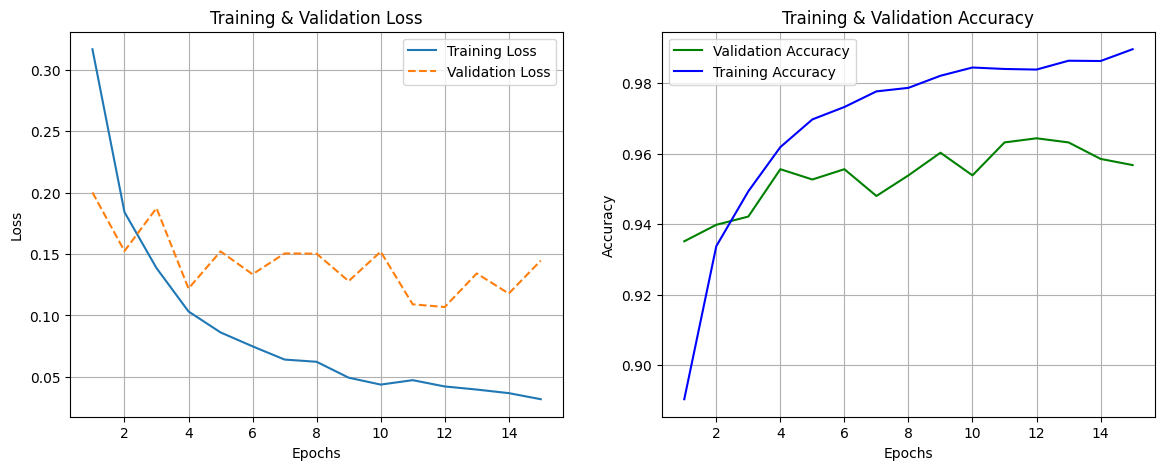


Evaluating on Test Set...
Final Test Loss: 0.1621
Final Test Accuracy: 96.05%


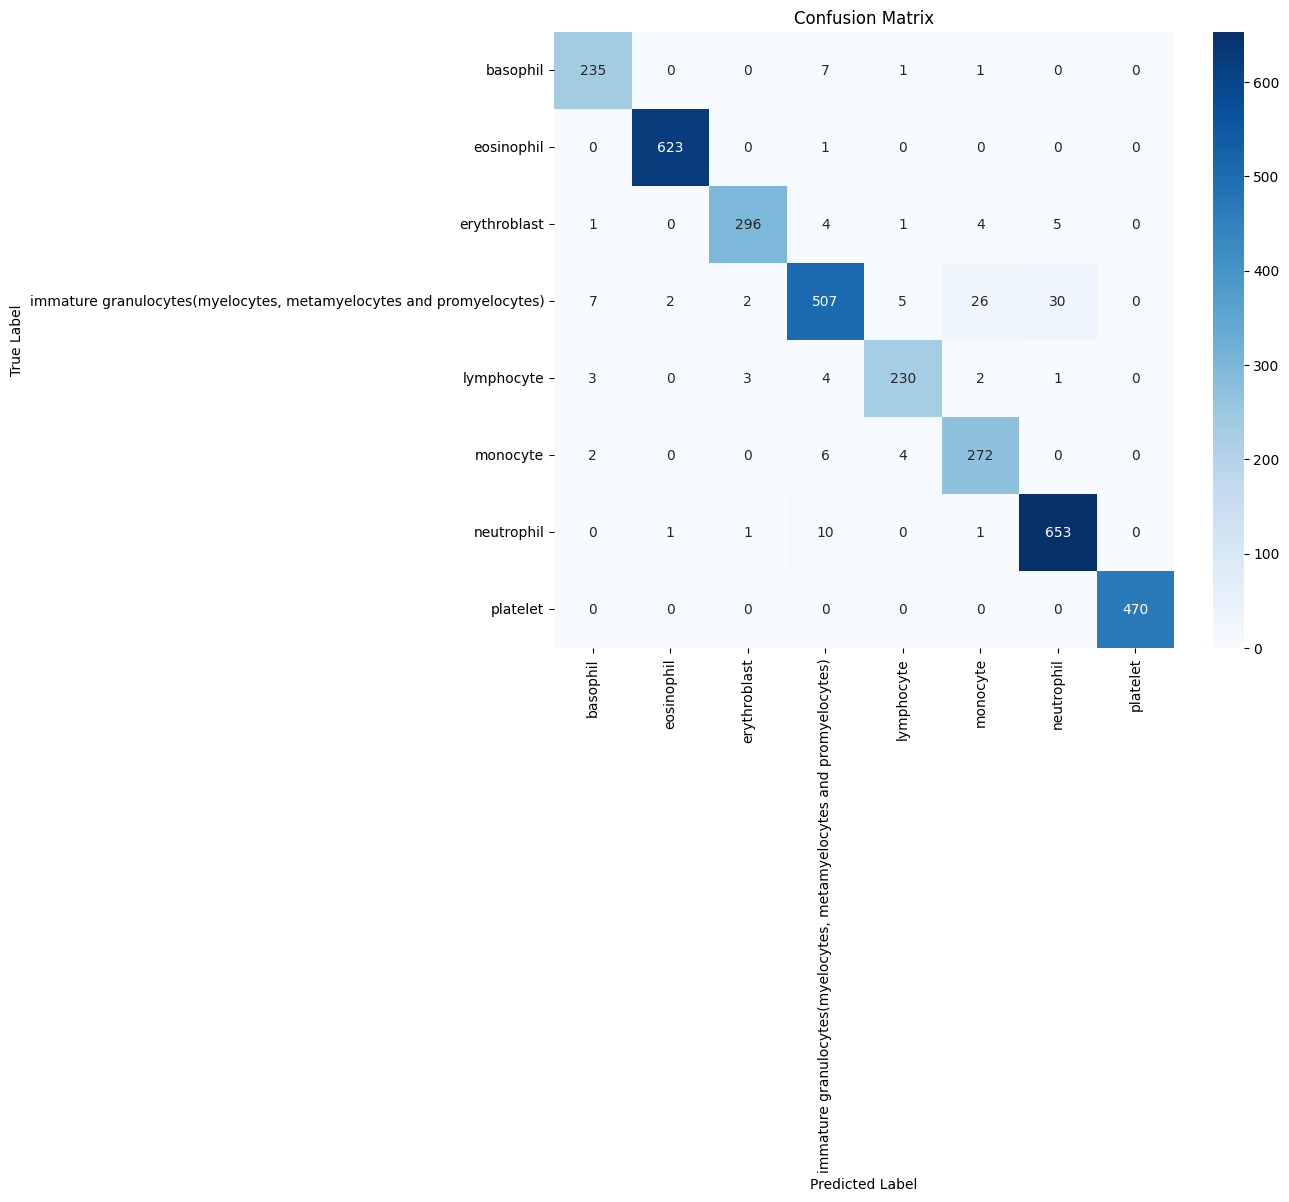


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.95      0.96      0.96       244
                                                         eosinophil       1.00      1.00      1.00       624
                                                       erythroblast       0.98      0.95      0.97       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.94      0.88      0.91       579
                                                         lymphocyte       0.95      0.95      0.95       243
                                                           monocyte       0.89      0.96      0.92       284
                                                         neutrophil       0.95      0.98      0.96       666
                                                           platelet       1.00      1.00      1.00     

In [ ]:
# Hyperparameters
# Seed for reproducibility
torch.manual_seed(42)
# Define epochs
EPOCHS = 15
# Define learning rate
learning_rate = 1e-4

# We choose optimizer only for the parameters that have been set as trainable (requires_grad=True)
optimizer_fine = torch.optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

print(f"Starting Fine Tuning")
history_tr = run_training(transfer_model, train_dataloader_fine2, val_dataloader_fine2, optimizer_fine, criterion, device, EPOCHS)

class_names = [labels_map[str(i)] for i in range(8)]
evaluate_and_visualize(transfer_model, test_dataloader_fine2, criterion, device, history_tr, class_names)

# 3. Μικρός Vision Transformer (DeiT)


In [ ]:
# Independent run for easy use
import timm # Import the timm library for Vision Transformers
from medmnist import BloodMNIST

# Create dataset splits (train, validation, test)
# 'size=28' specifies the image resolution (28x28)
train_dataset = BloodMNIST(split='train', download=True, size=28)
val_dataset = BloodMNIST(split='val', download=True, size=28)
test_dataset = BloodMNIST(split='test', download=True, size=28)

In [ ]:
# 1. Training Transformation (with Data Augmentation)
# Includes Resize to 224x224 (as required by DeiT) and Normalization
train_transform_new = transforms.Compose([
    transforms.Resize(224), # Resize to 224x224 pixels, necessary for DeiT
    transforms.RandomHorizontalFlip(p=0.5),  # 50% probability for horizontal flip
    transforms.RandomRotation(degrees=10),   # Random rotation +/- 10 degrees
    transforms.ToTensor(),                    # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean and standard deviation
                         std=[0.229, 0.224, 0.225]),
])

# 2. Validation & Test Transformation (WITHOUT Augmentation)
# Includes Resize to 224x224 and Normalization
eval_transform_new = transforms.Compose([
    transforms.Resize(224), # Resize to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # ImageNet mean and standard deviation
                         std=[0.229, 0.224, 0.225]),
])

# 3. Define Datasets with appropriate transformations
train_dataset = BloodMNIST(
    split='train',
    download=True,
    size=28,
    transform=train_transform_new
)

val_dataset = BloodMNIST(
    split='val',
    download=True,
    size=28,
    transform=eval_transform_new
)

test_dataset = BloodMNIST(
    split='test',
    download=True,
    size=28,
    transform=eval_transform_new
)

In [ ]:
BATCH_SIZE_TIM = 32 # Smaller batch size for ViT

train_dataloader_tim = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE_TIM, shuffle=True)
val_dataloader_tim = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE_TIM, shuffle=False)
test_dataloader_tim = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE_TIM, shuffle=False)

print("DataLoaders are ready!")

DataLoaders are ready!


In [ ]:
# Load pre-trained DeiT (Tiny version)
vit_model = timm.create_model('deit_tiny_patch16_224', pretrained=True) # pretrained=True loads weights from ImageNet

# "Freeze" all parameters of the base model
for param in vit_model.parameters():
    param.requires_grad = False

# Adapt Classifier Head
num_in_features = vit_model.head.in_features # Number of incoming features to the head
vit_model.head = nn.Linear(num_in_features, 8) # 8 classes for BloodMNIST

# Transfer the model to the device
vit_model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


Starting Feature Extraction (Only Head) for 15 epochs...
Starting training on cuda for 15 epochs...
loss: 2.805218  [   32/11959]
loss: 1.244782  [ 3232/11959]
loss: 0.928959  [ 6432/11959]
loss: 0.937498  [ 9632/11959]
Epoch 1/15 | Train Loss: 1.0182 | Val Loss: 0.8858 | Val Acc: 0.7179
loss: 0.599363  [   32/11959]
loss: 0.596407  [ 3232/11959]
loss: 0.467477  [ 6432/11959]
loss: 0.883157  [ 9632/11959]
Epoch 2/15 | Train Loss: 0.6496 | Val Loss: 0.7238 | Val Acc: 0.7652
loss: 0.531845  [   32/11959]
loss: 0.649052  [ 3232/11959]
loss: 0.484101  [ 6432/11959]
loss: 0.485890  [ 9632/11959]
Epoch 3/15 | Train Loss: 0.5705 | Val Loss: 0.6598 | Val Acc: 0.7810
loss: 0.677172  [   32/11959]
loss: 0.249794  [ 3232/11959]
loss: 0.777167  [ 6432/11959]
loss: 0.328635  [ 9632/11959]
Epoch 4/15 | Train Loss: 0.5299 | Val Loss: 0.6397 | Val Acc: 0.7915
loss: 0.645125  [   32/11959]
loss: 0.484618  [ 3232/11959]
loss: 0.379244  [ 6432/11959]
loss: 0.346159  [ 9632/11959]
Epoch 5/15 | Train Loss:

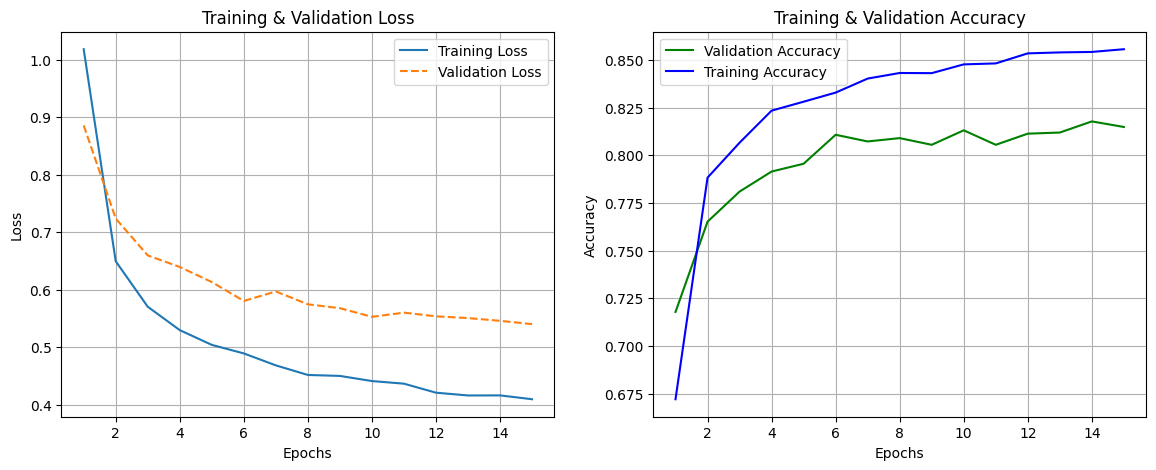


Evaluating on Test Set...
Final Test Loss: 0.5369
Final Test Accuracy: 81.23%


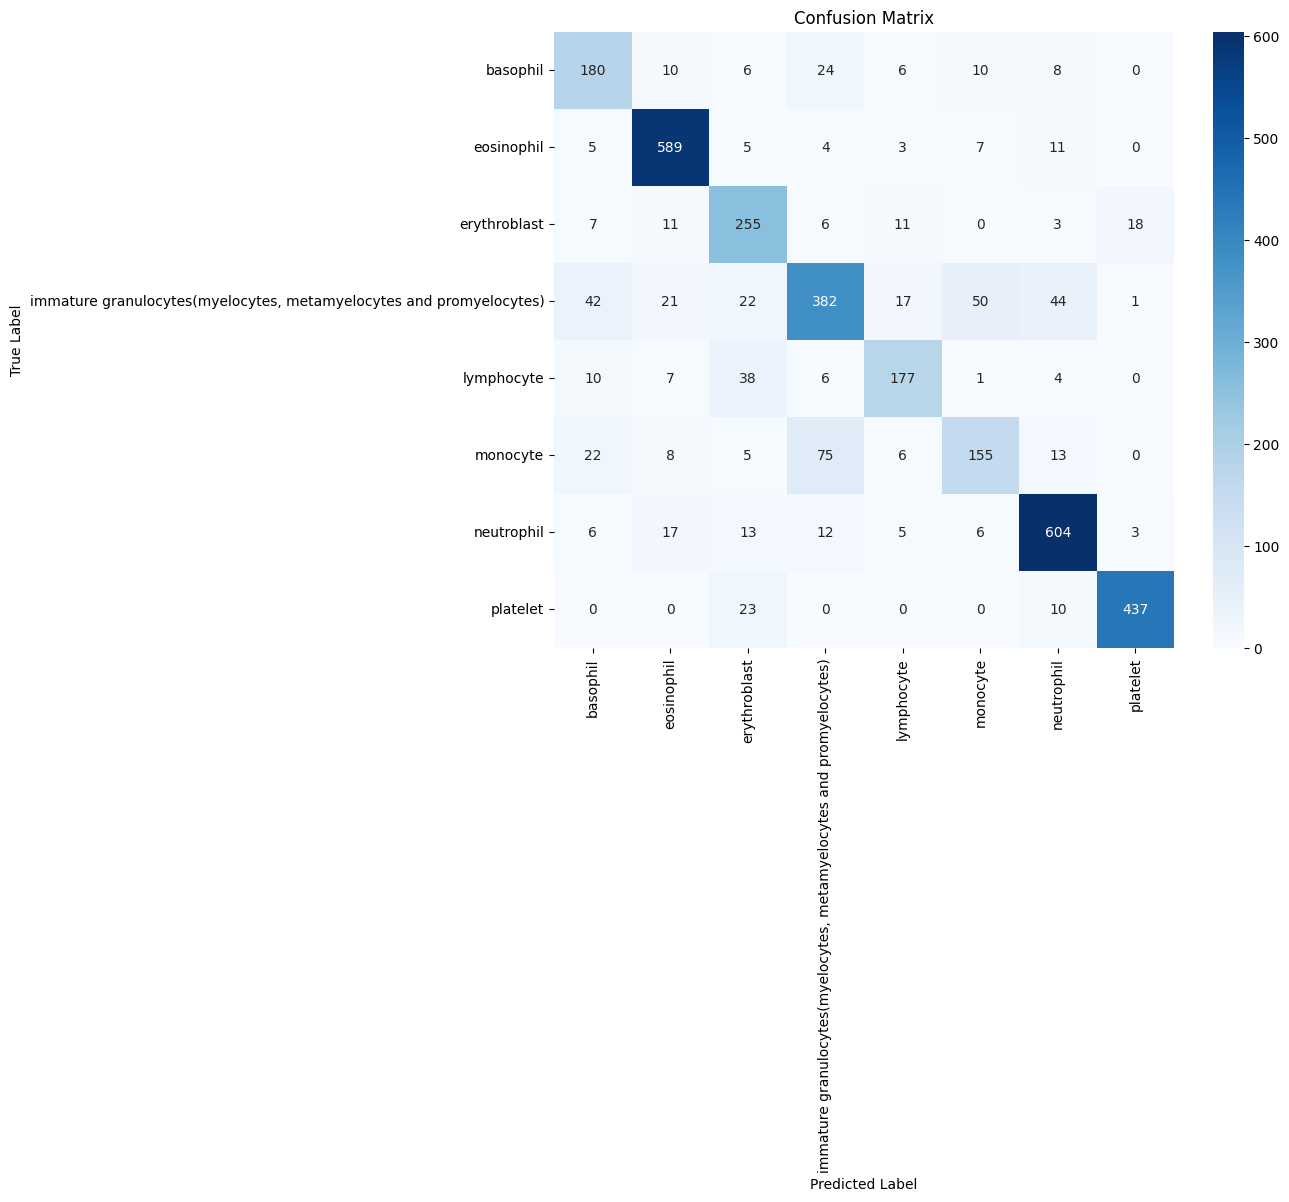


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.66      0.74      0.70       244
                                                         eosinophil       0.89      0.94      0.92       624
                                                       erythroblast       0.69      0.82      0.75       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.75      0.66      0.70       579
                                                         lymphocyte       0.79      0.73      0.76       243
                                                           monocyte       0.68      0.55      0.60       284
                                                         neutrophil       0.87      0.91      0.89       666
                                                           platelet       0.95      0.93      0.94     

In [ ]:
# Hyperparameters
EPOCHS_FE = 15 # Fewer epochs for feature extraction
LR_FE = 1e-3

# Optimizer trains only the classifier head
optimizer_fe = torch.optim.Adam(vit_model.head.parameters(), lr=LR_FE)
criterion = nn.CrossEntropyLoss()

print(f"Starting Feature Extraction (Only Head) for {EPOCHS_FE} epochs...")
history_vit_fe = run_training(vit_model, train_dataloader_tim, val_dataloader_tim, optimizer_fe, criterion, device, EPOCHS_FE)

class_names = [labels_map[str(i)] for i in range(8)]
evaluate_and_visualize(vit_model, test_dataloader_tim, criterion, device, history_vit_fe, class_names)

Starting training on cuda for 10 epochs...
loss: 0.176568  [   16/11959]
loss: 0.588046  [ 1616/11959]
loss: 0.423697  [ 3216/11959]
loss: 0.689074  [ 4816/11959]
loss: 0.910980  [ 6416/11959]
loss: 0.556123  [ 8016/11959]
loss: 0.476458  [ 9616/11959]
loss: 0.527623  [11216/11959]
Epoch 1/10 | Train Loss: 0.4211 | Val Loss: 0.4522 | Val Acc: 0.8458
loss: 0.245850  [   16/11959]
loss: 0.172503  [ 1616/11959]
loss: 0.075073  [ 3216/11959]
loss: 0.189079  [ 4816/11959]
loss: 0.519244  [ 6416/11959]
loss: 0.233187  [ 8016/11959]
loss: 0.173135  [ 9616/11959]
loss: 0.219975  [11216/11959]
Epoch 2/10 | Train Loss: 0.3401 | Val Loss: 0.3499 | Val Acc: 0.8808
loss: 0.180506  [   16/11959]
loss: 0.312997  [ 1616/11959]
loss: 0.125240  [ 3216/11959]
loss: 0.251770  [ 4816/11959]
loss: 0.360801  [ 6416/11959]
loss: 0.270913  [ 8016/11959]
loss: 0.105146  [ 9616/11959]
loss: 0.085090  [11216/11959]
Epoch 3/10 | Train Loss: 0.2817 | Val Loss: 0.4124 | Val Acc: 0.8528
loss: 0.272192  [   16/11959]


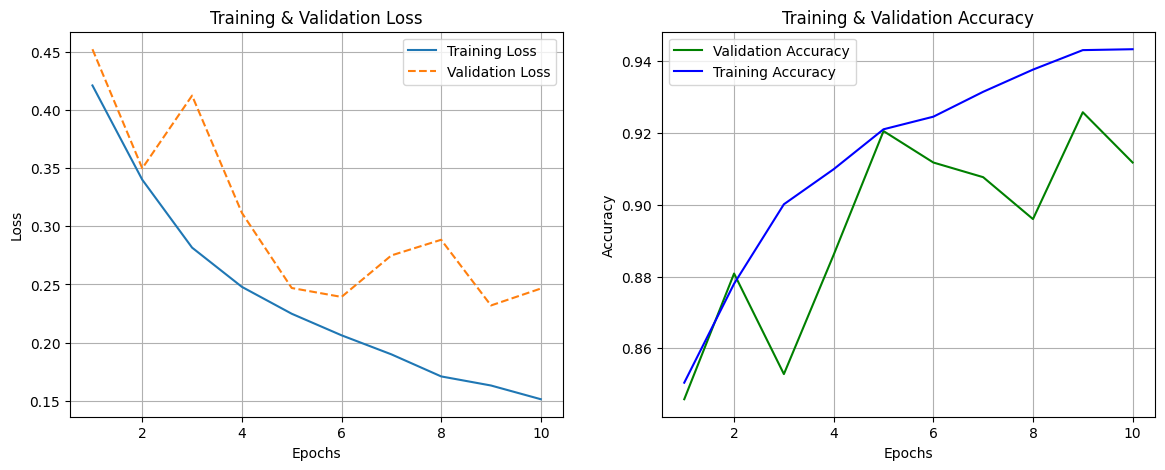


Evaluating on Test Set...
Final Test Loss: 0.2932
Final Test Accuracy: 90.73%


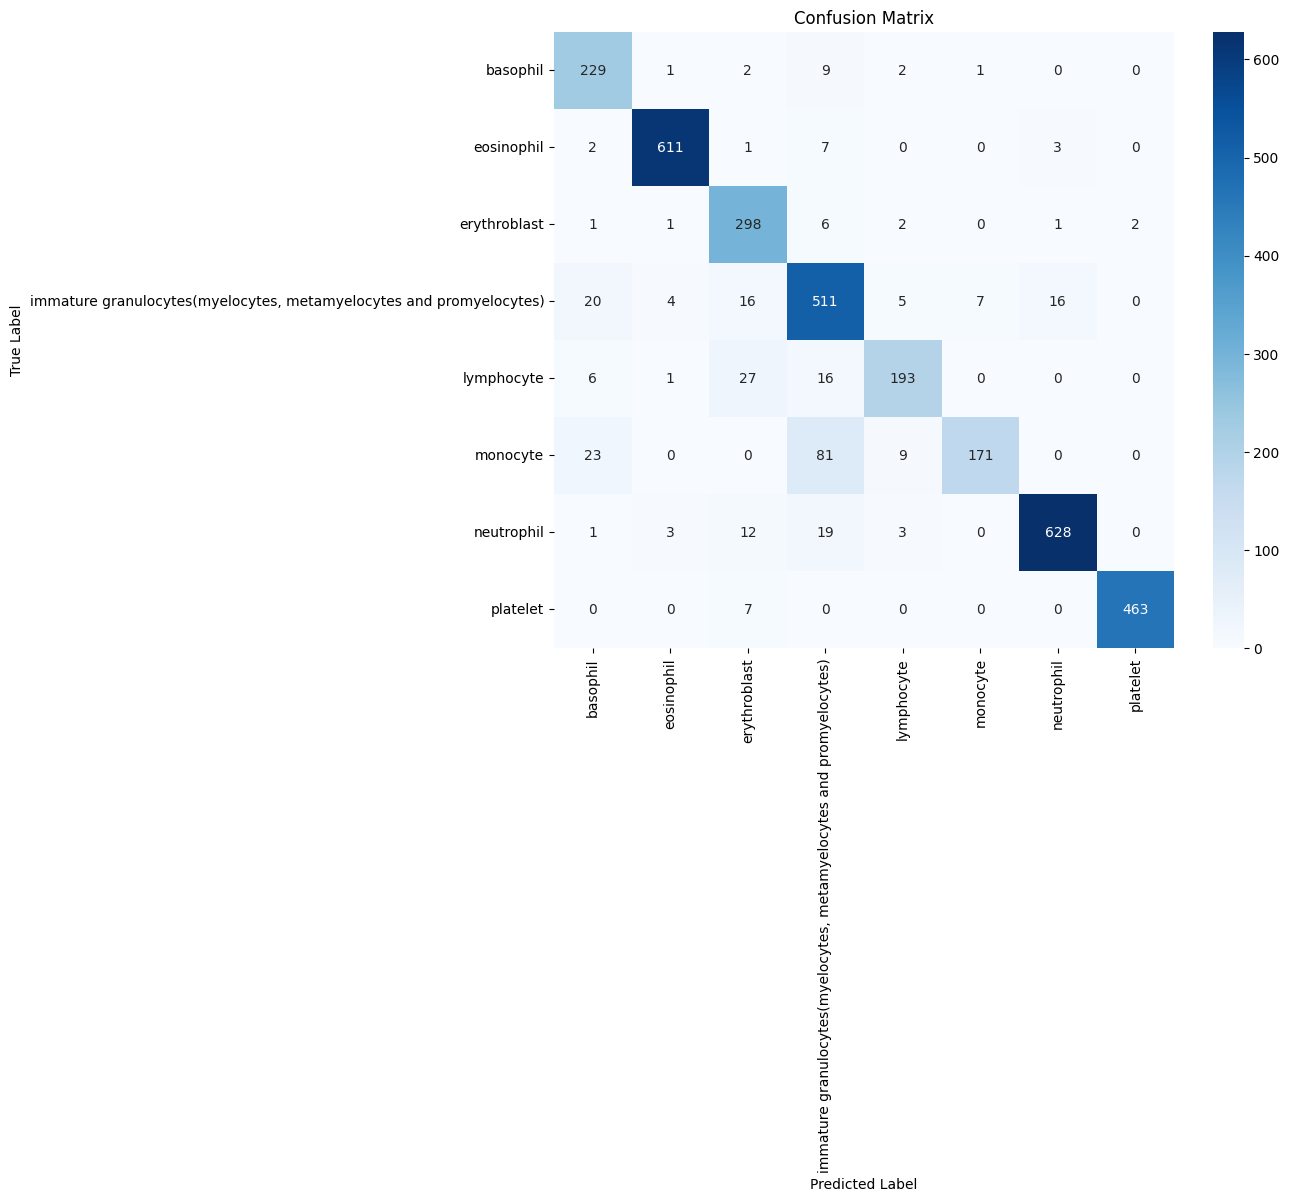


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.81      0.94      0.87       244
                                                         eosinophil       0.98      0.98      0.98       624
                                                       erythroblast       0.82      0.96      0.88       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.79      0.88      0.83       579
                                                         lymphocyte       0.90      0.79      0.84       243
                                                           monocyte       0.96      0.60      0.74       284
                                                         neutrophil       0.97      0.94      0.96       666
                                                           platelet       1.00      0.99      0.99     

In [ ]:
BATCH_SIZE_FT = 16
train_loader_ft = DataLoader(train_dataset, batch_size=BATCH_SIZE_FT, shuffle=True)
val_loader_ft = DataLoader(val_dataset, batch_size=BATCH_SIZE_FT, shuffle=False)
test_loader_ft = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE_FT, shuffle=False)

# Unfreeze the last Blocks
for param in vit_model.blocks[-2:].parameters(): # Unfreeze the last 2 transformer blocks
    param.requires_grad = True

# Also, the norm and head must be unfrozen
for param in vit_model.norm.parameters():
    param.requires_grad = True
for param in vit_model.head.parameters():
    param.requires_grad = True

# Fine-Tuning Hyperparamaters
EPOCHS_FT = 10
LR_FT = 1e-4

# Optimizer for the unfrozen parameters
optimizer_ft = torch.optim.Adam(filter(lambda p: p.requires_grad, vit_model.parameters()), lr=LR_FT)
criterion = nn.CrossEntropyLoss()
history_vit_ft = run_training(vit_model, train_loader_ft, val_loader_ft, optimizer_ft, criterion, device, EPOCHS_FT)

# Evaluation
class_names = [labels_map[str(i)] for i in range(8)]
evaluate_and_visualize(vit_model, test_loader_ft, criterion, device, history_vit_ft, class_names)

# Βελτιώσεις

Starting Advanced Experiment: Weighted Loss + Scheduler + WD
loss: 2.533578  [   64/11959]
loss: 0.946599  [ 6464/11959]
Epoch 1/40 | Train Loss: 1.0979 | Val Loss: 0.8990 | Val Acc: 0.8651 | LR: 0.000998
loss: 0.931254  [   64/11959]
loss: 0.810499  [ 6464/11959]
Epoch 2/40 | Train Loss: 0.8759 | Val Loss: 0.7967 | Val Acc: 0.9065 | LR: 0.000994
loss: 0.798556  [   64/11959]
loss: 0.788677  [ 6464/11959]
Epoch 3/40 | Train Loss: 0.8194 | Val Loss: 0.8362 | Val Acc: 0.8843 | LR: 0.000986
loss: 0.818799  [   64/11959]
loss: 0.764027  [ 6464/11959]
Epoch 4/40 | Train Loss: 0.7855 | Val Loss: 0.7508 | Val Acc: 0.9095 | LR: 0.000976
loss: 0.661488  [   64/11959]
loss: 0.637035  [ 6464/11959]
Epoch 5/40 | Train Loss: 0.7652 | Val Loss: 0.7928 | Val Acc: 0.8966 | LR: 0.000962
loss: 0.891455  [   64/11959]
loss: 0.773423  [ 6464/11959]
Epoch 6/40 | Train Loss: 0.7488 | Val Loss: 0.8074 | Val Acc: 0.8937 | LR: 0.000946
loss: 0.787786  [   64/11959]
loss: 0.840546  [ 6464/11959]
Epoch 7/40 | Tr

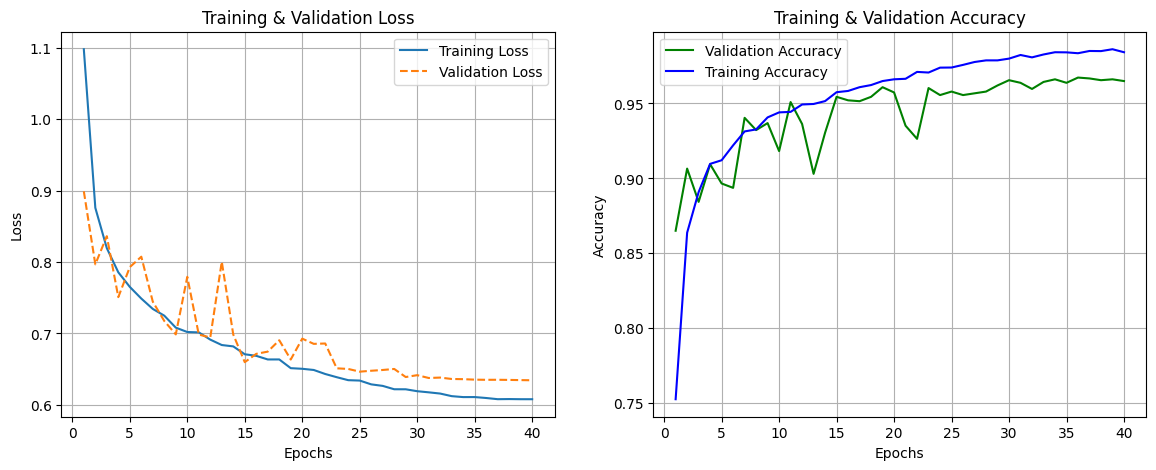


Evaluating on Test Set...
Final Test Loss: 0.6385
Final Test Accuracy: 96.96%


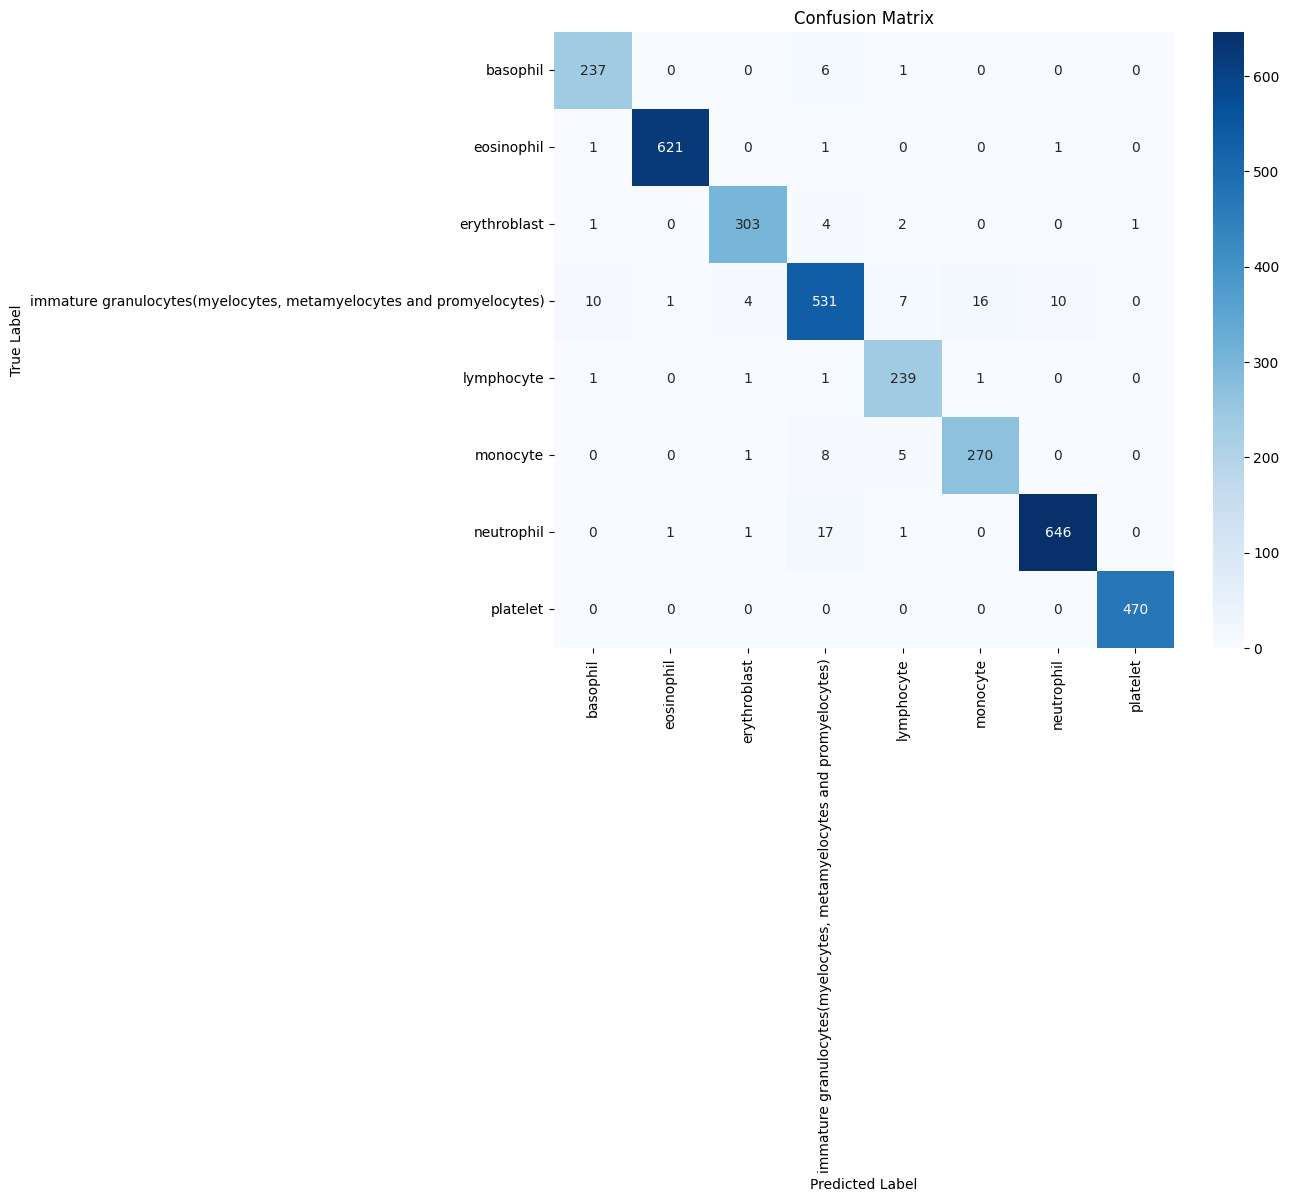


Classification Report:
                                                                     precision    recall  f1-score   support

                                                           basophil       0.95      0.97      0.96       244
                                                         eosinophil       1.00      1.00      1.00       624
                                                       erythroblast       0.98      0.97      0.98       311
immature granulocytes(myelocytes, metamyelocytes and promyelocytes)       0.93      0.92      0.93       579
                                                         lymphocyte       0.94      0.98      0.96       243
                                                           monocyte       0.94      0.95      0.95       284
                                                         neutrophil       0.98      0.97      0.98       666
                                                           platelet       1.00      1.00      1.00     

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Model Definition (CNN with Dropout & Batch Norm)
class CNNWithDropout(nn.Module):
    def __init__(self, num_classes=8, drop_percent=0.5):
        super(CNNWithDropout, self).__init__()
        # Input: 28x28 -> Output: 14x14
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Input: 14x14 -> Output: 7x7
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Input: 7x7 -> Output: 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(p=drop_percent)
        self.flatten_dim = 128 * 3 * 3
        self.fc = nn.Linear(self.flatten_dim, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.flatten(1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

EPOCHS = 40
LR = 1e-3
WEIGHT_DECAY = 1e-4
DROP_PERCENT = 0.2  # Optimal values

# Model Initialization
model = CNNWithDropout(num_classes=8, drop_percent=DROP_PERCENT).to(device)

# Calculate weights for Class Imbalance
class_counts = torch.tensor([852, 2181, 1085, 2026, 849, 993, 2330, 1643], dtype=torch.float)
weights = 1.0 / class_counts      # Inverse frequency
weights = weights / weights.sum() # Normalize
weights = weights.to(device)

# Define Loss with Label Smoothing
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

# Optimizer with Weight Decay
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Learning Rate Scheduler (Cosine Annealing)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print("Starting Advanced Experiment: Weighted Loss + Scheduler + WD")

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(EPOCHS):
    # Training Step
    train_loss, train_acc = train_loop(model, train_dataloader, optimizer, criterion, device)

    # Validation Step
    val_loss, val_acc, _, _ = test_loop(model, val_dataloader, criterion, device)

    # Scheduler Step (Update LR after validation)
    scheduler.step()

    # Logging
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")

# Final Evaluation
print("Evaluating on Test Set...")
class_names = [labels_map[str(i)] for i in range(8)]
evaluate_and_visualize(model, test_dataloader, criterion, device, history, class_names)